### SUMMARY FROM RAYMOND'S ANALYSIS(2/24/2024)




1.   album is most important predictive variable(according to boruta but not sure if we can use that)
2.   Many violations of assumptions.
3.   powerTransform doesn't work on our data unless we modify it(powertransform doesn't work with negatives).
4.   Reduced model of transform is not significantly different(can we use that?).
*   Much lower $R^2(\approx .02)$
*   holds to assumptions slightly better but still not very good

If you havent downloaded Boruta please use below.

Note that I've uploaded images of all the boruta packages so this should be unnecessary

In [ ]:
install.packages("Boruta")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppEigen’, ‘ranger’




In [ ]:
install.packages('car')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘Rcpp’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘lme4’




Loading Packages

In [ ]:
suppressMessages(library(tidyverse))
#library(Boruta)
library(MASS)
library(car)


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




Cleaning Taylor Data

In [ ]:
taylor_swift <- suppressMessages(read_csv('taylor_swift_spotify.csv'))
ts_data <- taylor_swift %>%
  #filter((str_detect(str_to_lower(album), 'deluxe') | str_detect(album, 'Taylor\'s Version')) &
  #!str_detect(album, 'Live') & !str_detect(album, 'Stadium'))
  #use when you want to select only deleuxe and taylor's version albums
  filter(!str_detect(str_to_lower(album), 'deluxe') & !str_detect(album, 'Edition') &
    !str_detect(album, 'Live') & !str_detect(album, 'Stadium'))
  #use when you want to select all non special editions(no deluxe, live, stadiums --- still includes taylors version)
ts_data['Taylors_Version'] = 0
ts_data$Taylors_Version[str_detect(ts_data$album,"Taylors Version")] = 1
ts_data_clean <- ts_data %>%
  dplyr::select(name, album, release_date, acousticness:Taylors_Version)

ts_data_pos <- ts_data_clean %>%
  mutate(across(where(is.numeric), ~ . + abs(min(., na.rm = TRUE)) + 1))



ERROR: Error: 'taylor_swift_spotify.csv' does not exist in current working directory ('/content').


Looking for good variables

In [ ]:

#ts_data <- suppressMessages(read_csv("taylor_swift_spotify_cleaned.csv"))
bor <- Boruta(popularity ~ ., data = ts_data_clean)

Plotting and Variable Isolation

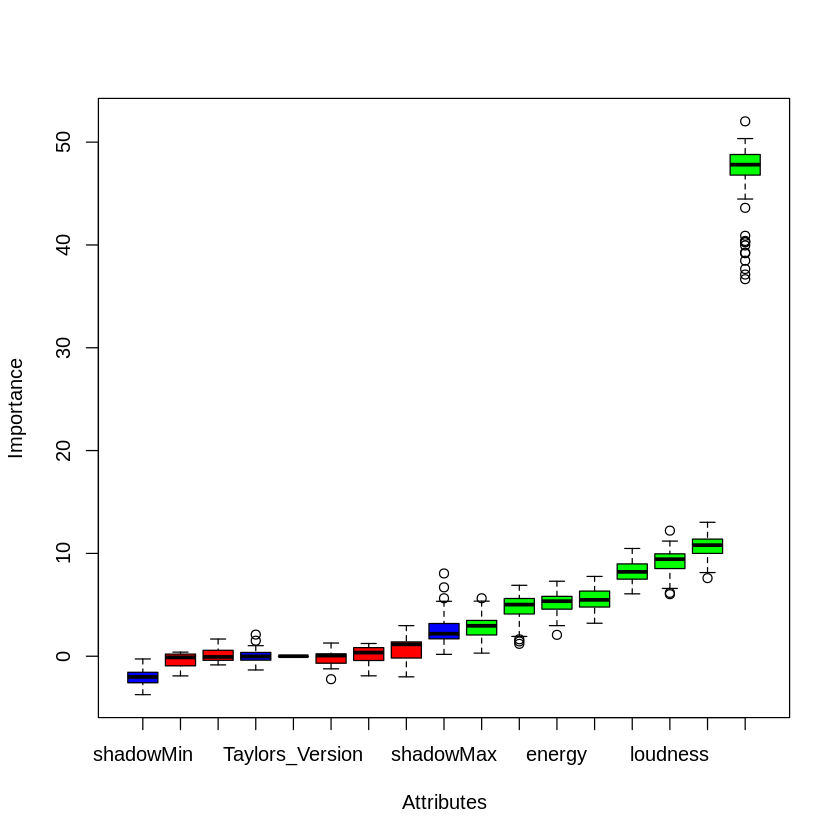

In [ ]:
plot(bor)

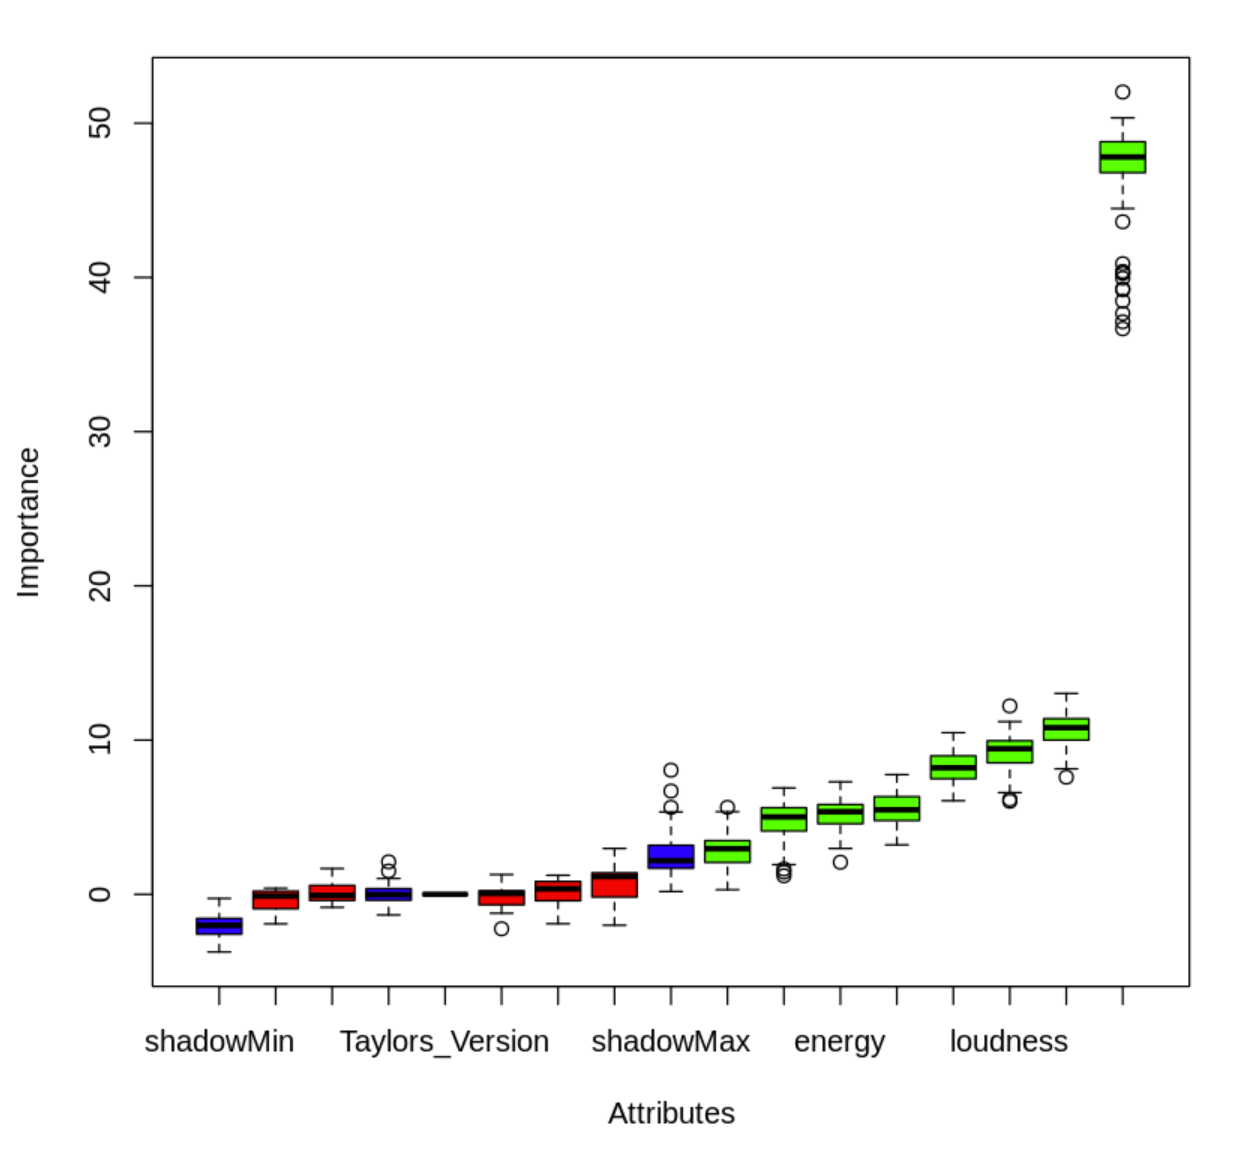

above is image of the output(so you dont have to keep downloading boruta)

In [ ]:
important_vars <- getSelectedAttributes(bor, withTentative = FALSE) #withTentative = FALSE means it wont include the uncretain vars, might want to try TRUE
print(important_vars)

[1] "album"            "release_date"     "acousticness"     "energy"          
[5] "instrumentalness" "loudness"         "speechiness"      "duration_ms"     


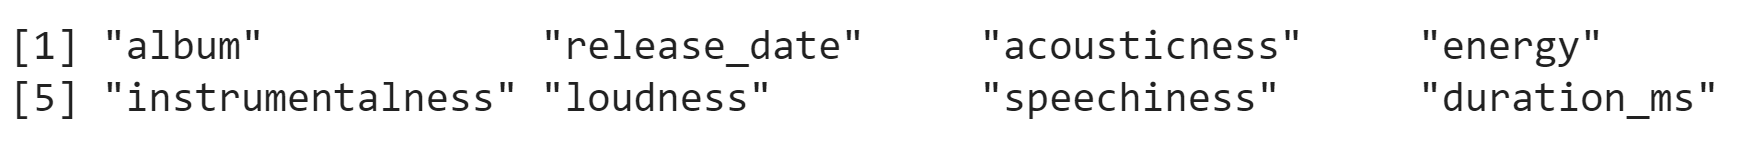

Best predictor(Numerical)

In [ ]:
important_scores <- bor$ImpHistory
imp_score <- as_tibble(important_scores) %>%
  summarise(across(everything(), sum)) %>%
  pivot_longer(cols = everything(), names_to = 'Variables', values_to = 'Importance') %>%
  arrange(desc(Importance))
imp_score %>%
  filter(Importance >= imp_score$Importance[length(important_vars)])
  #Above grabs only the rows with the importance score greater than or equal to
  #the importance score of the last important variable
  #(since there are only length(important_vars) number of variables)


Variables        Importance
1 release_date     3601.4341 
2 album             815.9603 
3 loudness          713.1013 
4 speechiness       637.2450 
5 duration_ms       427.4081 
6 energy            404.1397 
7 acousticness      364.9868 
8 instrumentalness  223.1273

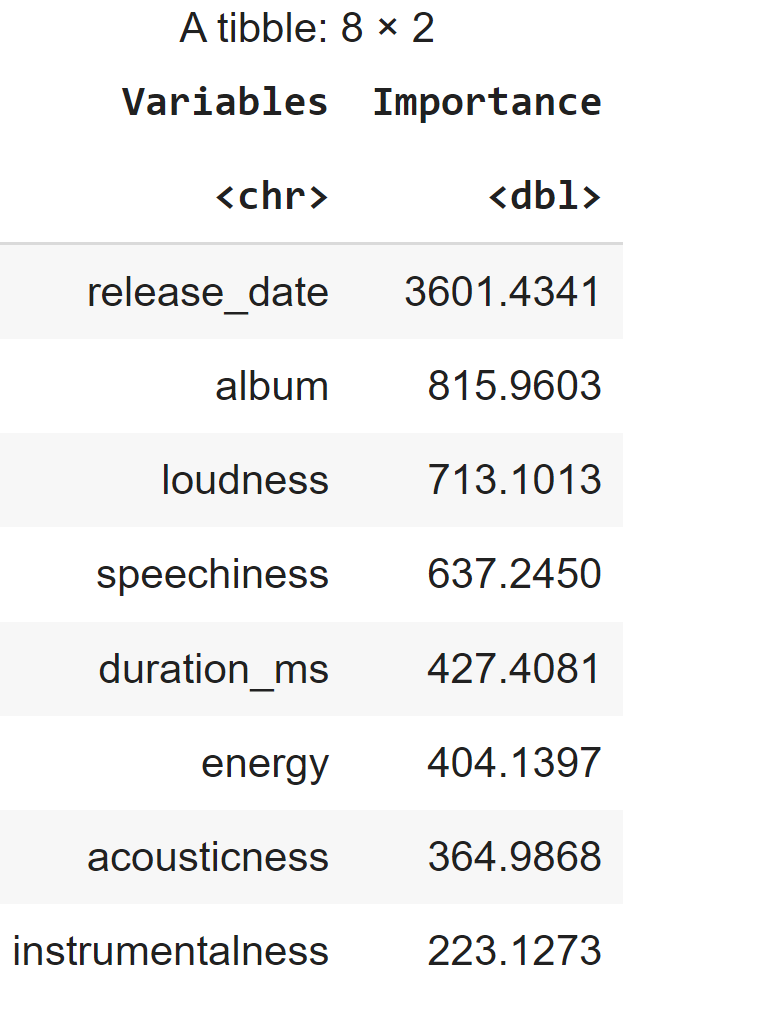

Release_date being the biggest next to album implies that popularity is often grouped by album(release date follows album). This makes sense, can confirm by running an lm on averages of album but this significantly changes the research question(becomes what variables makes an album popular instead of a song).

We can also somehow control for variables(maybe make tons of dummy variables) which represent album. I propose we also delete the release date category since imo its just a worse version of album(unless we want to figure out her most popular era, but that wouldn't require an lm, a simple scatter plot would do).

In [ ]:
ts_alb_lm <- lm(popularity ~ as.factor(album), data= ts_data_clean) #I THINK the as.factor converts album into a dummy variable well
summary(ts_alb_lm)

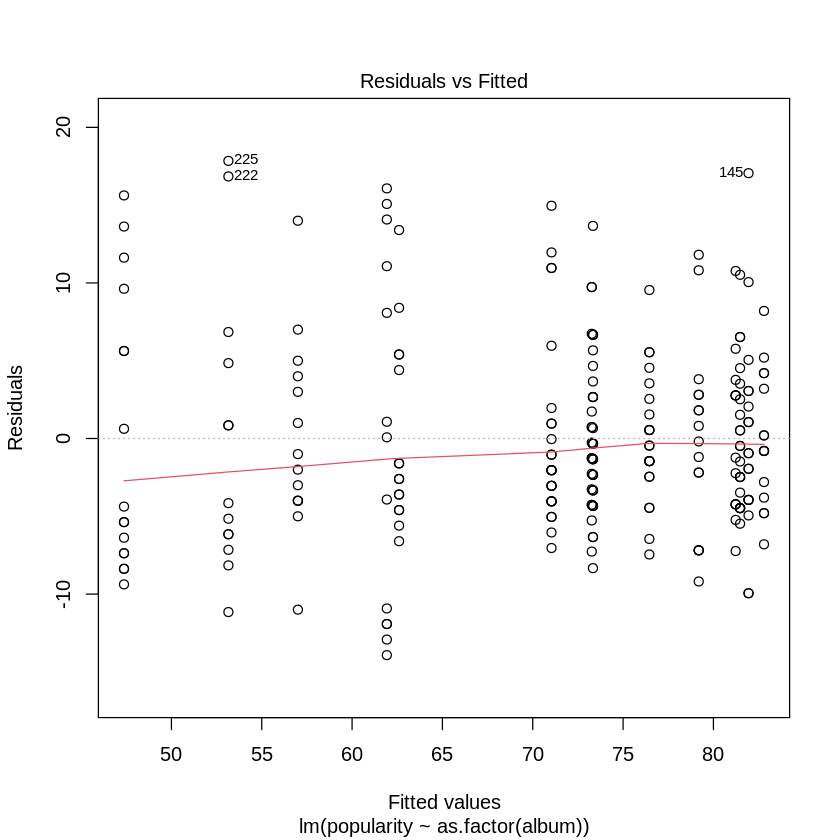

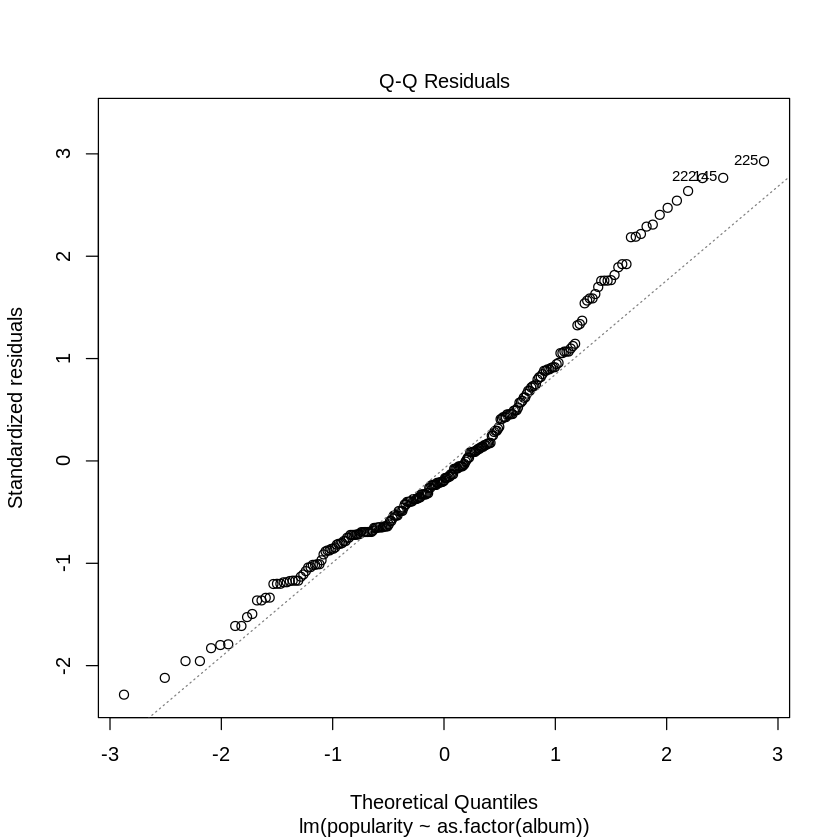

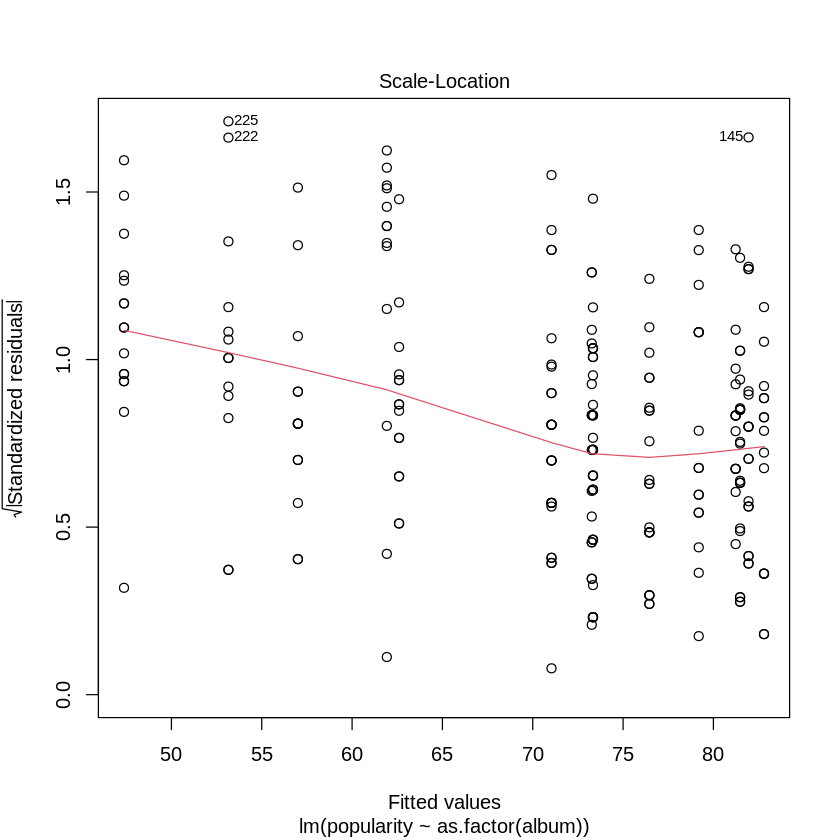

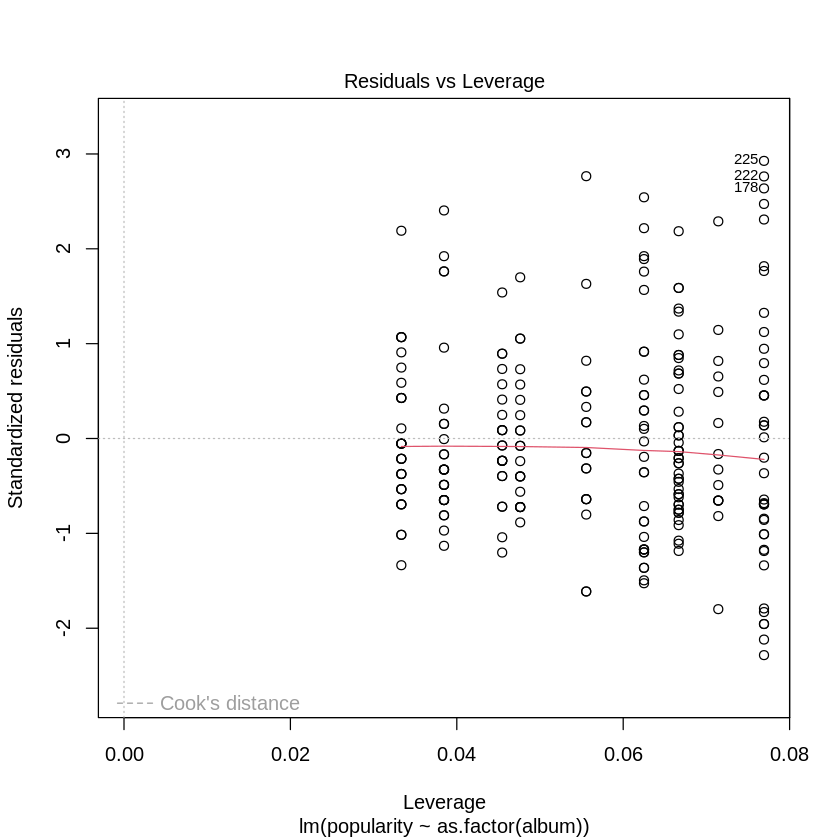

In [ ]:
plot(ts_alb_lm)

In [ ]:
taylor_lm <- lm(popularity ~ loudness*speechiness*duration_ms*energy*
  acousticness * instrumentalness*Taylors_Version, data = ts_data_clean)
summary(taylor_lm)

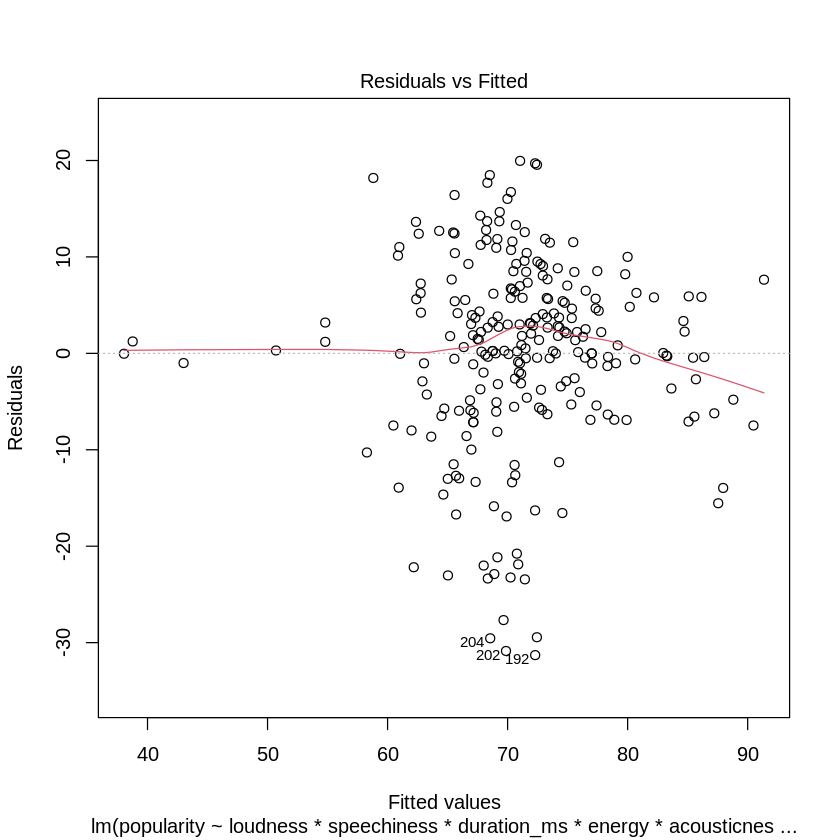

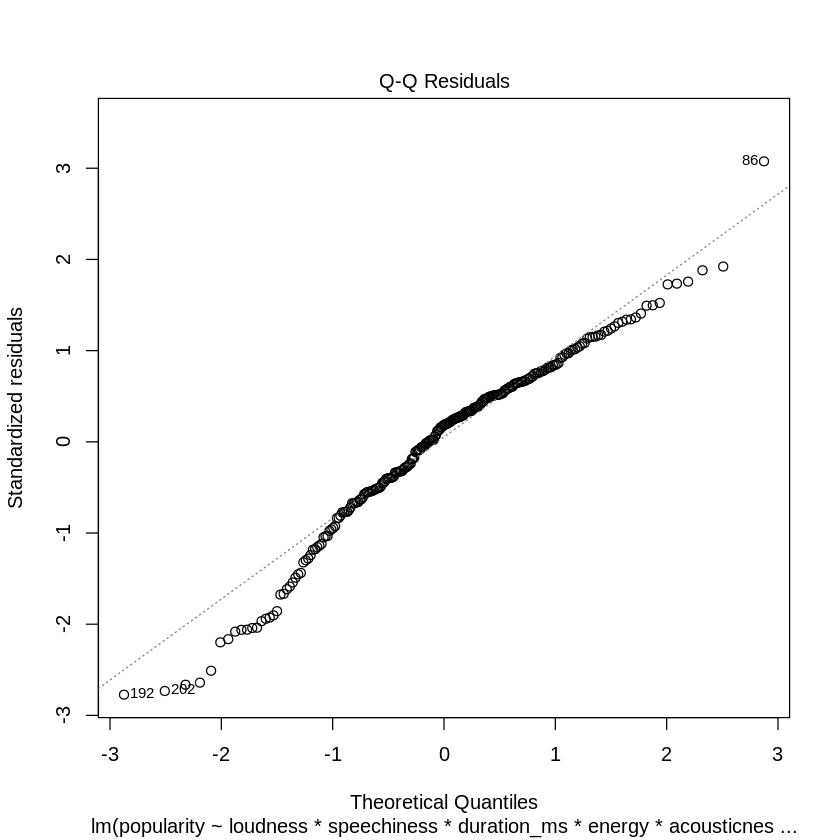

Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”
Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”


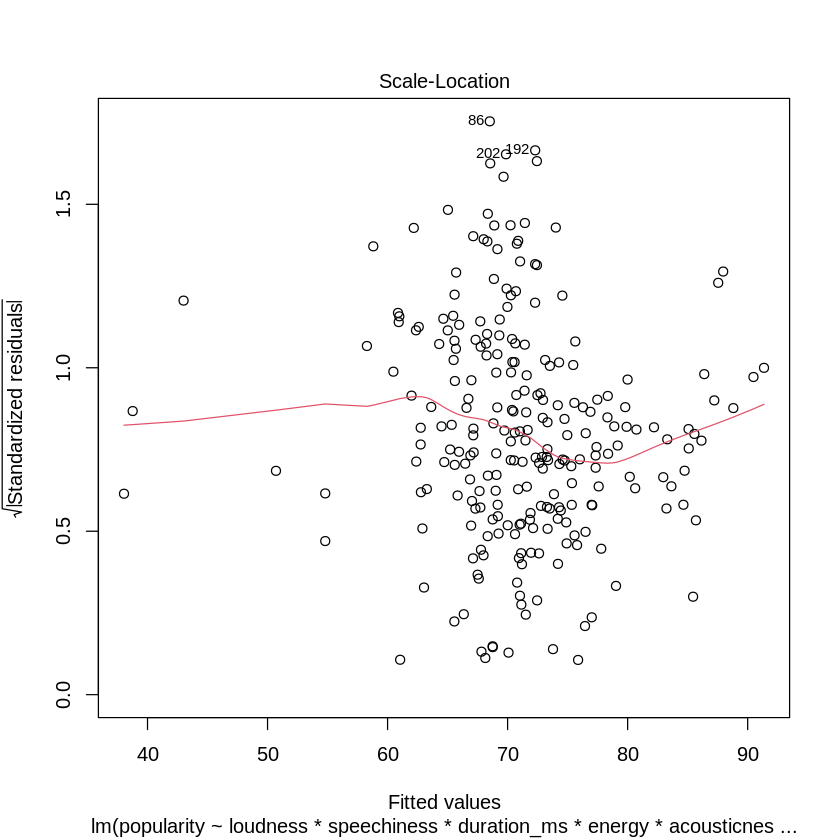

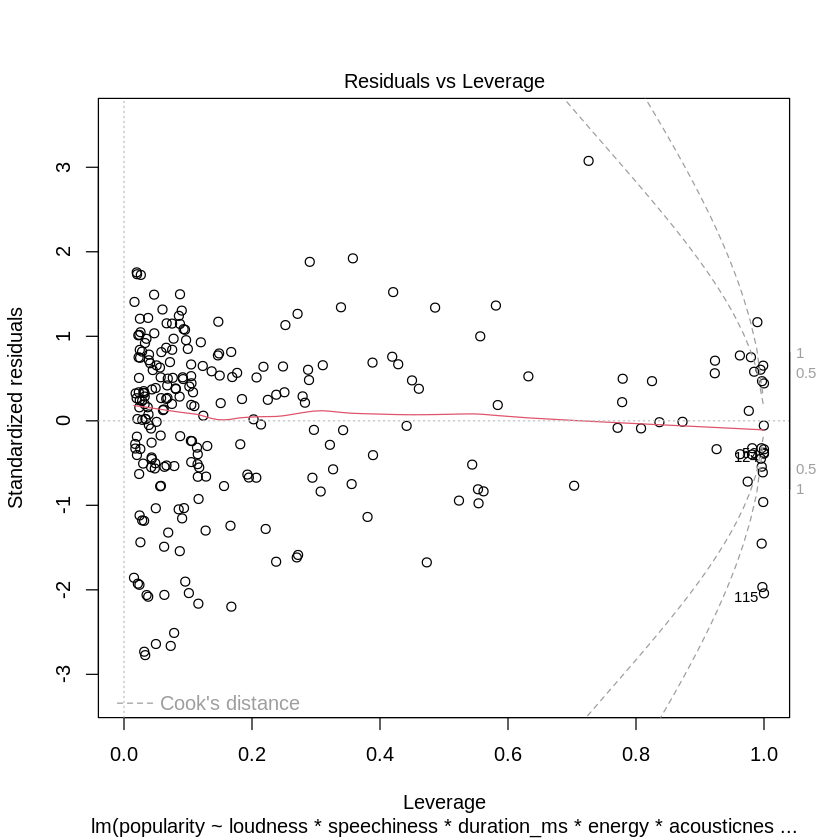

In [ ]:
plot(taylor_lm)

Violation of variance of residuals, normality, and some bad leverage points it looks like.

In [ ]:
bc <-boxcox(taylor_lm, lambda = seq(-100, 100, by = .01))
lambda <- bc$x[which.max(bc$y)]
lambda

Best lambda seems to be almost 3

In [ ]:
#print(ts_data_pos %>% dplyr::select(instrumentalness)) #cant find any significant difference between this column and the others

summary(car::powerTransform(cbind(popularity, loudness, speechiness, duration_ms, energy,
  acousticness)~1, data = ts_data_pos)) #for some reason when I add instrumentalness theres an error

Above doesn't work unless we modify the columns only to have positive numbers(can add the min of each column to each column--professor said its ok just to transform original data not the positively defined data)

In [ ]:
trans_pwr <- ts_data_clean %>%
  mutate(popularity^3.75, loudness ^ 1.4, speechiness ^-33, duration_ms^-2, energy^2, acousticness^-2.7)


In [ ]:
trans <- ts_data_clean %>%
  mutate(across(where(is.numeric), ~.^3))
print(trans, n = 5)
trans %>% filter(if_any(everything(), is.na))

In [ ]:
trans_lm <- lm(popularity ~ loudness*speechiness*duration_ms*energy*
  acousticness * instrumentalness*Taylors_Version, data = trans) #I THINK the as.factor converts album into a dummy variable well
summary(trans_lm)
plot(trans_lm)


Call:
lm(formula = popularity ~ loudness * speechiness * duration_ms * 
    energy * acousticness * instrumentalness * Taylors_Version, 
    data = trans_pwr)

Residuals:
    Min      1Q  Median      3Q     Max 
-31.296  -5.188   1.193   6.046  19.960 

Coefficients: (64 not defined because of singularities)
                                                                                        Estimate
(Intercept)                                                                           -1.577e+02
loudness                                                                              -4.237e+01
speechiness                                                                            9.914e+02
duration_ms                                                                            5.750e-04
energy                                                                                 3.569e+02
acousticness                                                                          -6.568e+02
instrument

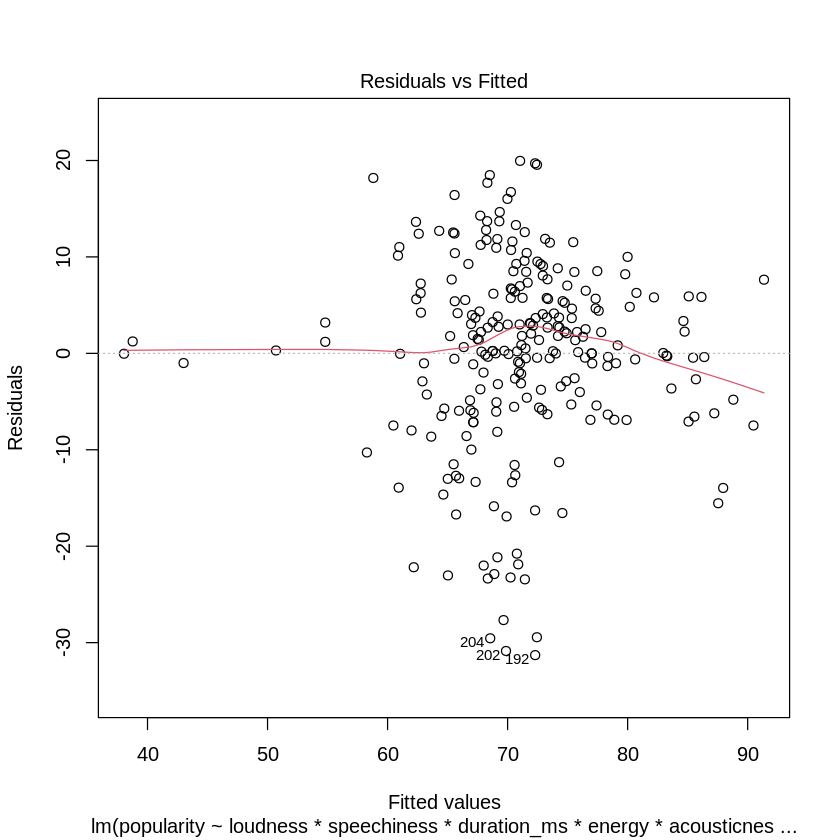

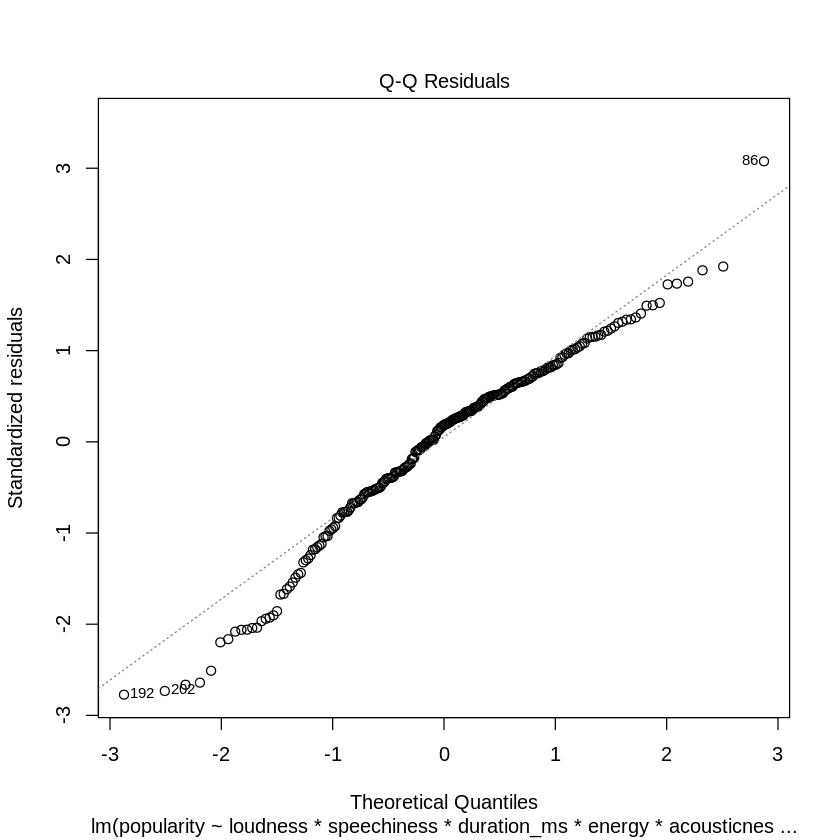

Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”
Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”


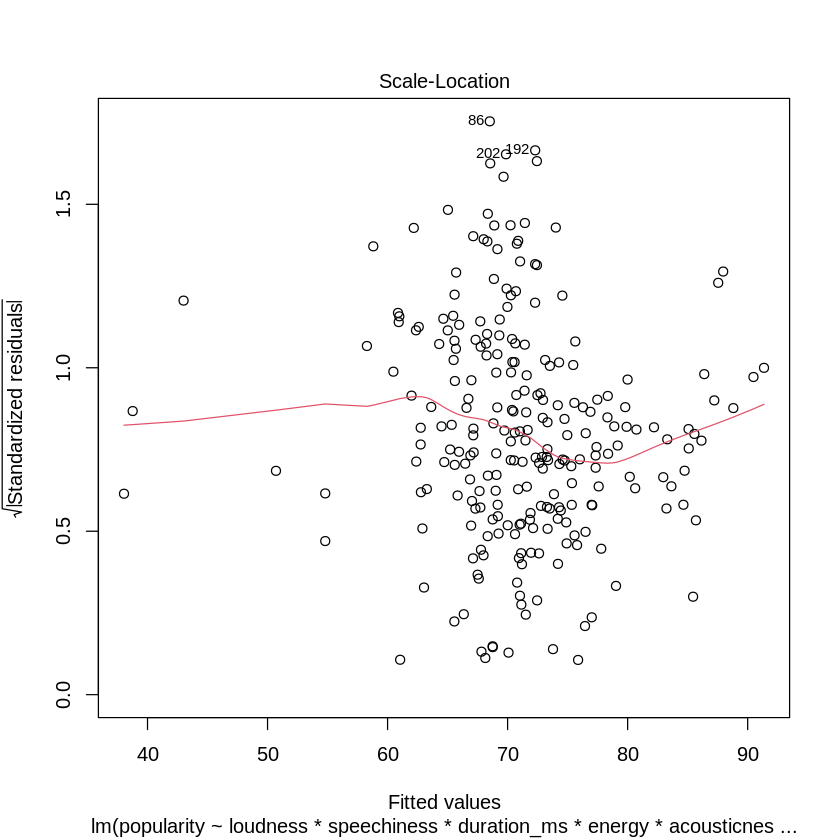

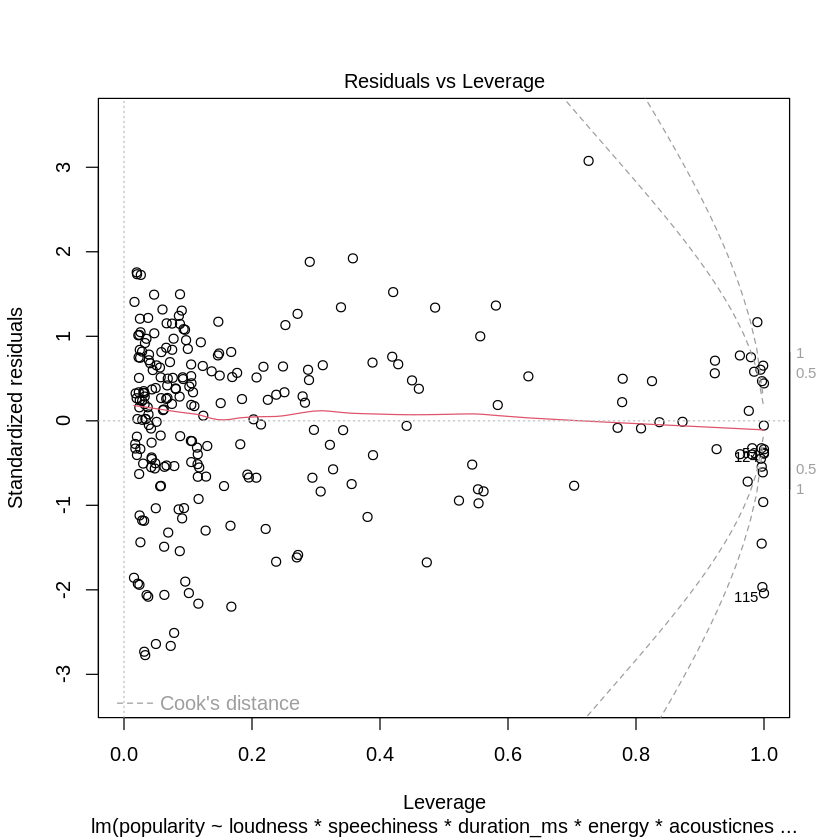

In [ ]:
trans_pwr_lm <- lm(popularity ~ loudness*speechiness*duration_ms*energy*
  acousticness * instrumentalness*Taylors_Version, data = trans_pwr) #I THINK the as.factor converts album into a dummy variable well
summary(trans_pwr_lm)
plot(trans_pwr_lm)

In [ ]:
taylor_red_alb <- lm(popularity ~ as.factor(album), data = trans)
taylor_red_box <- lm(popularity ~ (loudness + speechiness + duration_ms + energy +
  acousticness + instrumentalness)*Taylors_Version, data = trans)
taylor_red_pwr <- lm(popularity ~ (loudness + speechiness + duration_ms + energy +
  acousticness)*Taylors_Version, data = trans_pwr)


Call:
lm(formula = popularity ~ as.factor(album), data = trans)

Residuals:
    Min      1Q  Median      3Q     Max 
-187062  -59668  -25090   49837  409989 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                    261266      26851   9.730
as.factor(album)1989 (Taylor's Version)        284101      34166   8.315
as.factor(album)evermore                       137618      36686   3.751
as.factor(album)Fearless                       -97775      37973  -2.575
as.factor(album)Fearless (Taylor's Version)    104837      32886   3.188
as.factor(album)folklore                       243445      36149   6.734
as.factor(album)Lover                          299044      35238   8.487
as.factor(album)Midnights                      280908      37973   7.398
as.factor(album)Red                           -144137      36149  -3.987
as.factor(album)Red (Taylor's Version)         138101      32147   4.296
as.factor(album)reputat

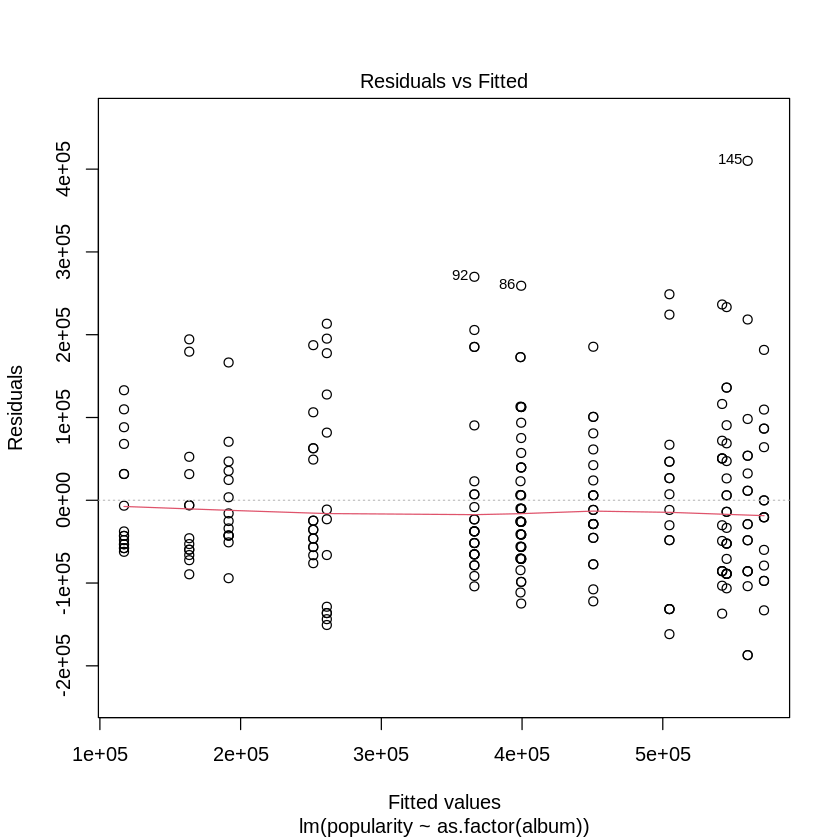

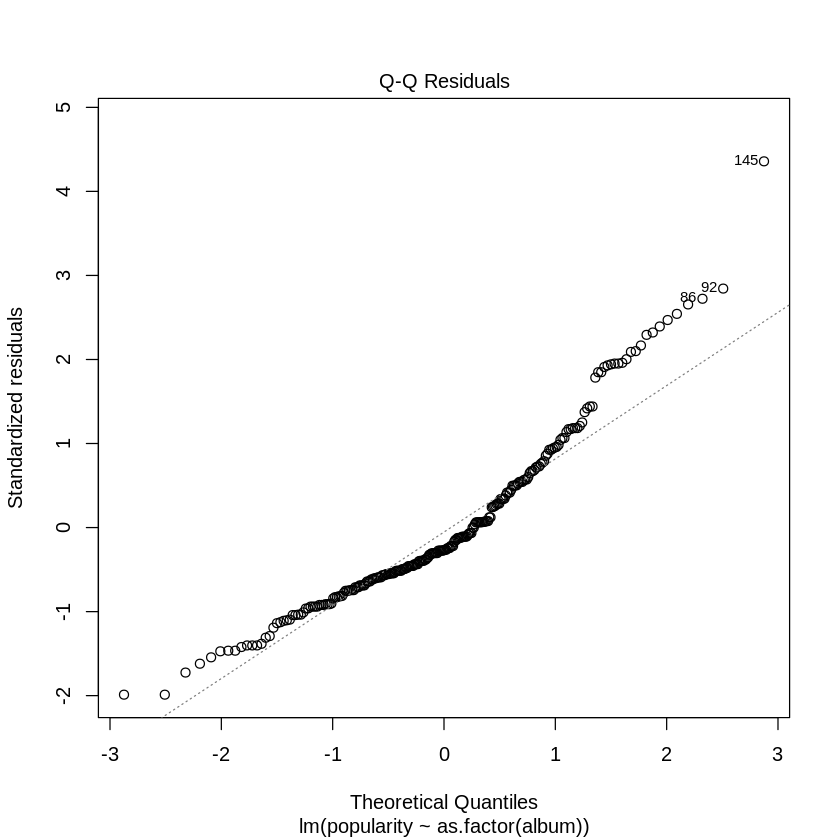

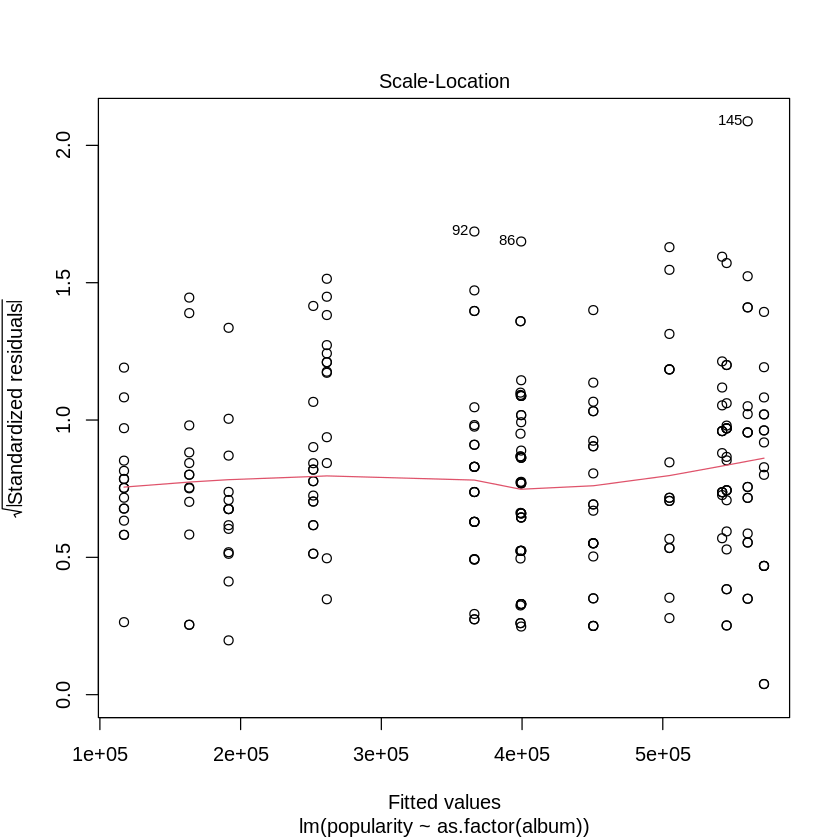

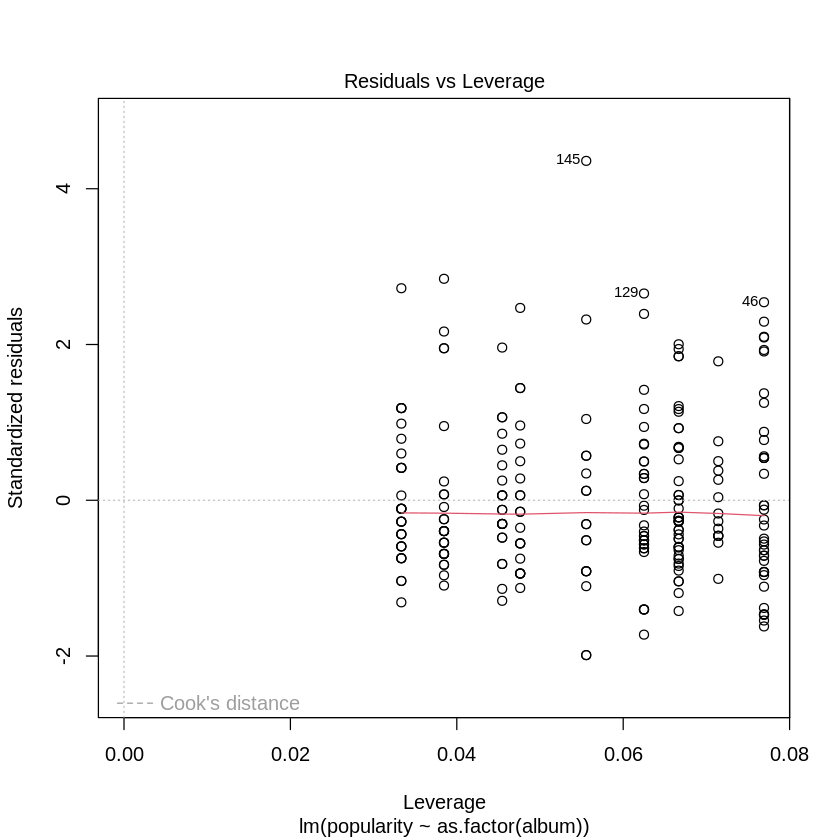

In [ ]:
summary(taylor_red_alb)
plot(taylor_red_alb)


Call:
lm(formula = popularity ~ (loudness + speechiness + duration_ms + 
    energy + acousticness + instrumentalness) * Taylors_Version, 
    data = trans)

Residuals:
    Min      1Q  Median      3Q     Max 
-402393 -117646   -1175  119231  587291 

Coefficients: (7 not defined because of singularities)
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       3.870e+05  3.363e+04  11.506   <2e-16 ***
loudness                         -4.817e+01  2.795e+01  -1.724   0.0861 .  
speechiness                       6.129e+05  1.146e+06   0.535   0.5934    
duration_ms                      -1.752e-13  6.824e-13  -0.257   0.7976    
energy                           -4.106e+04  7.238e+04  -0.567   0.5710    
acousticness                     -6.411e+04  6.819e+04  -0.940   0.3480    
instrumentalness                 -6.556e+05  1.599e+06  -0.410   0.6823    
Taylors_Version                          NA         NA      NA       NA    
loudness

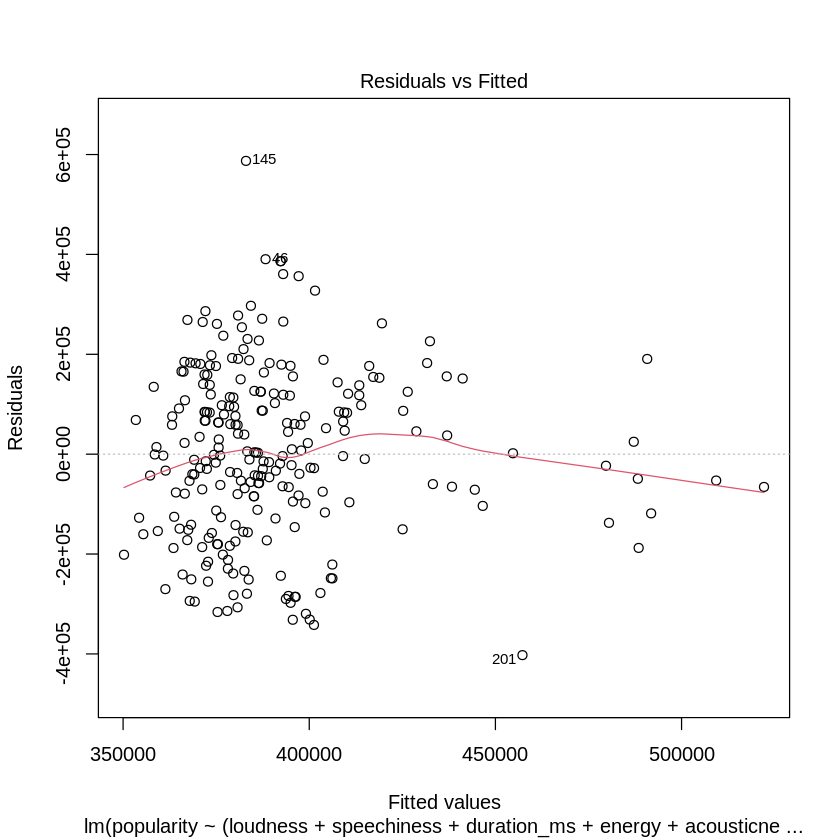

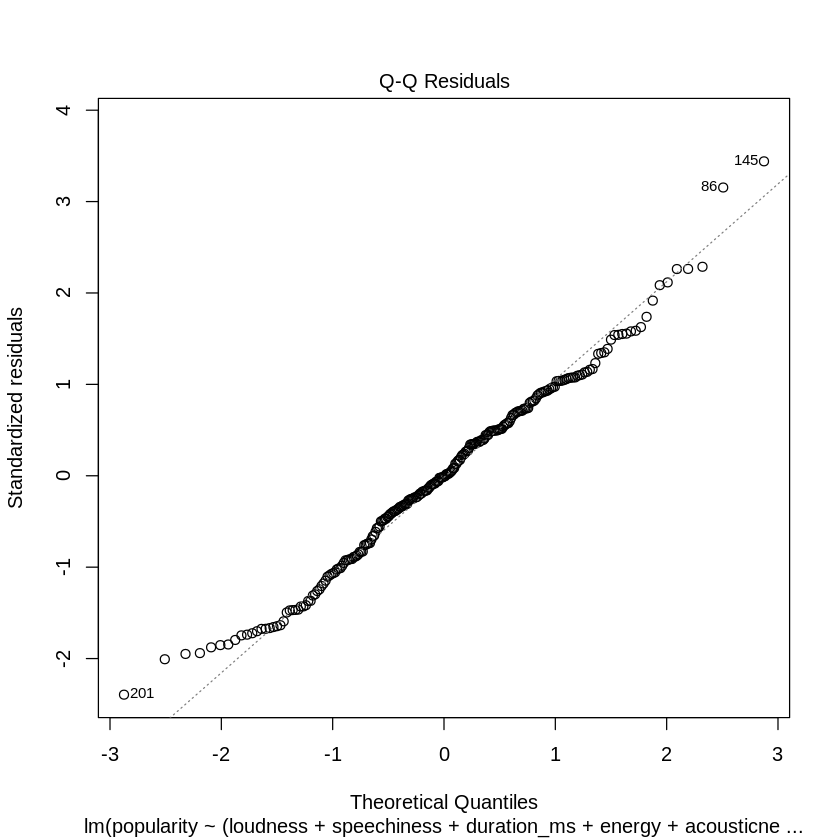

Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”
Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”


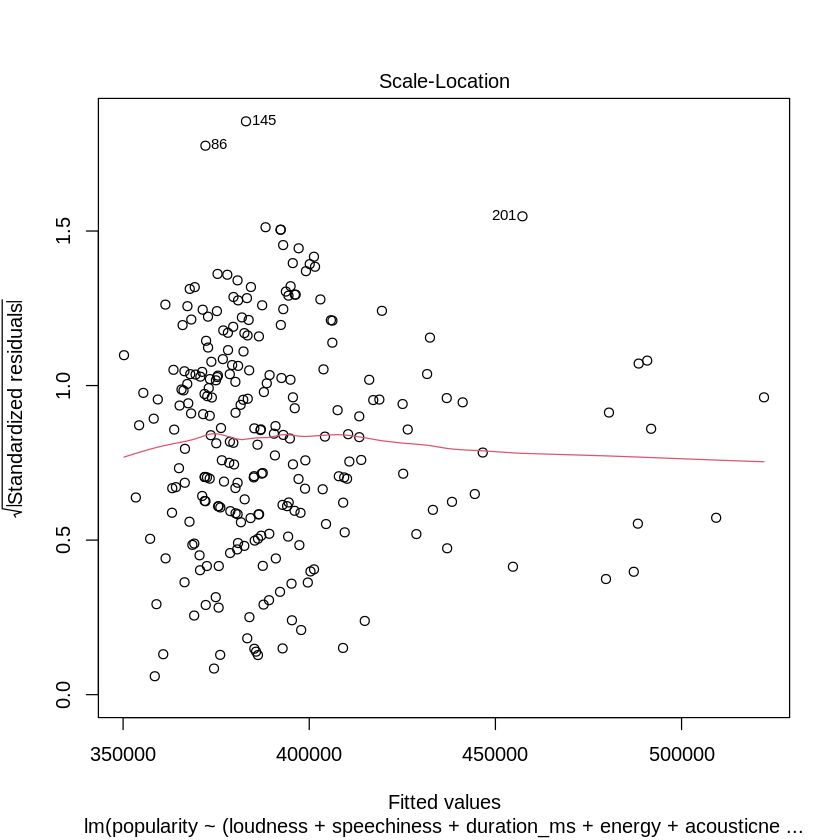

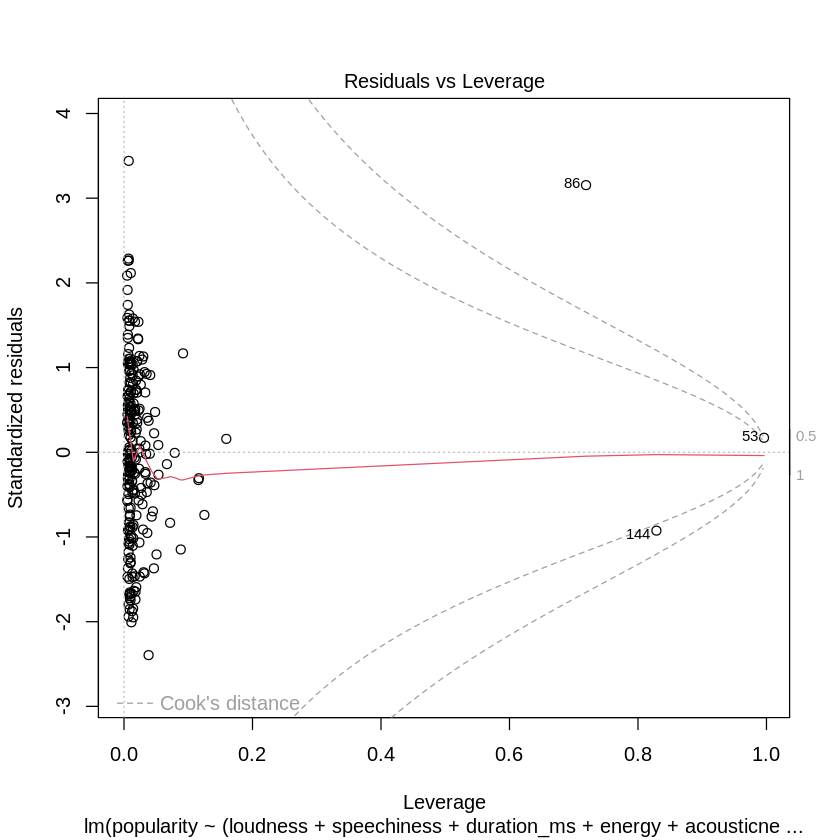

In [ ]:
summary(taylor_red_box)
plot(taylor_red_box)


Call:
lm(formula = popularity ~ (loudness + speechiness + duration_ms + 
    energy + acousticness) * Taylors_Version, data = trans_pwr)

Residuals:
    Min      1Q  Median      3Q     Max 
-35.508  -6.433   1.897   8.528  23.593 

Coefficients: (6 not defined because of singularities)
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   6.184e+01  9.255e+00   6.682 1.62e-10 ***
loudness                     -1.063e+00  5.199e-01  -2.044   0.0421 *  
speechiness                   3.950e+01  1.600e+01   2.470   0.0142 *  
duration_ms                  -1.324e-05  1.730e-05  -0.765   0.4448    
energy                        5.415e+00  7.392e+00   0.733   0.4645    
acousticness                 -1.188e+00  3.818e+00  -0.311   0.7559    
Taylors_Version                      NA         NA      NA       NA    
loudness:Taylors_Version             NA         NA      NA       NA    
speechiness:Taylors_Version          NA         NA      NA      

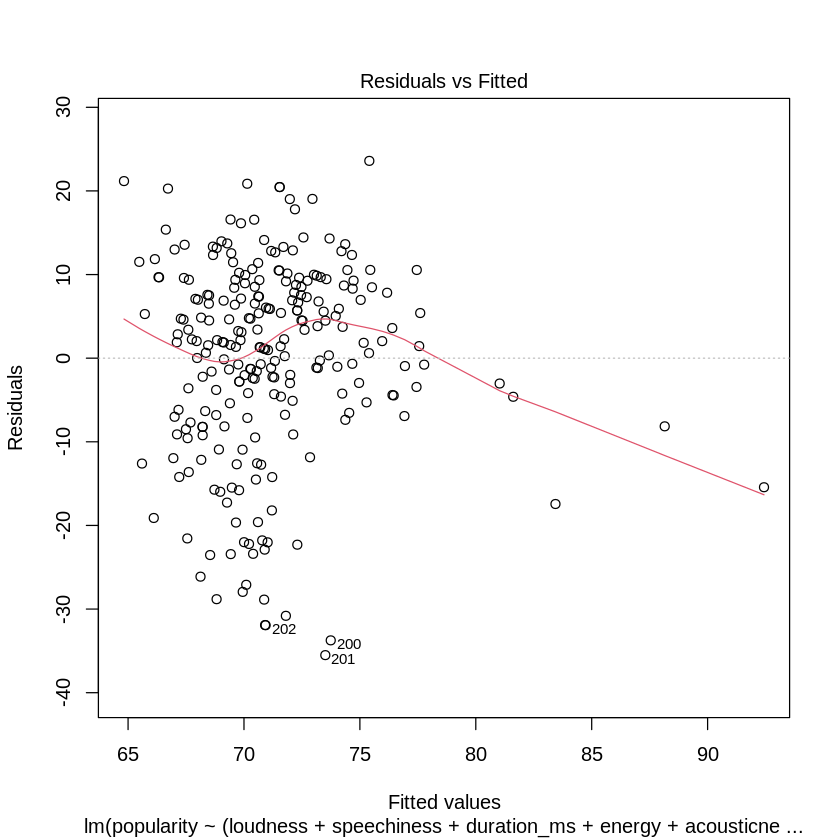

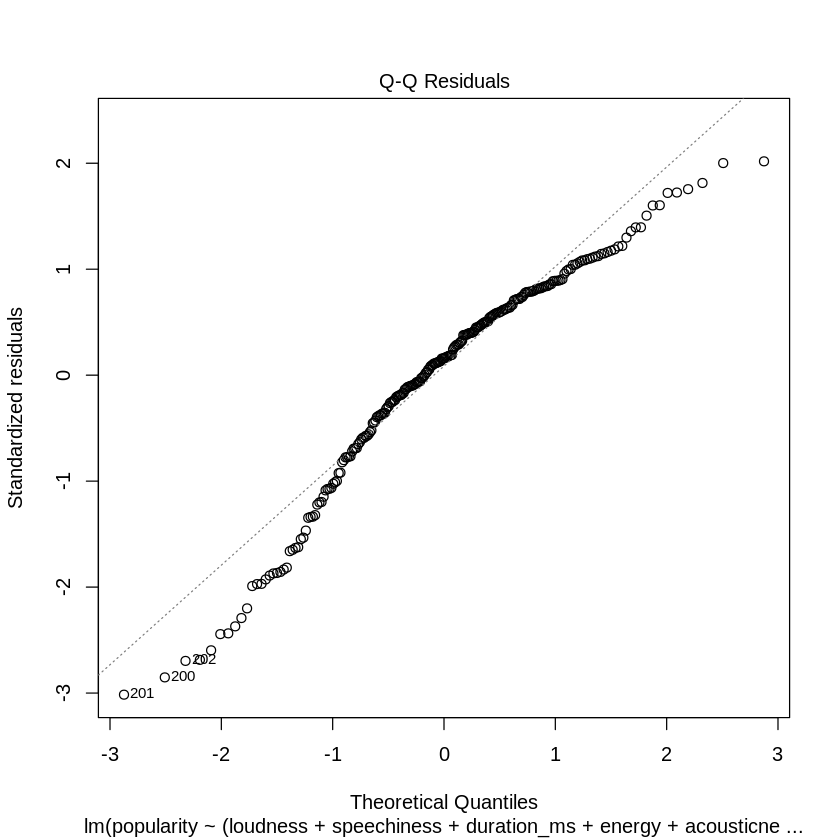

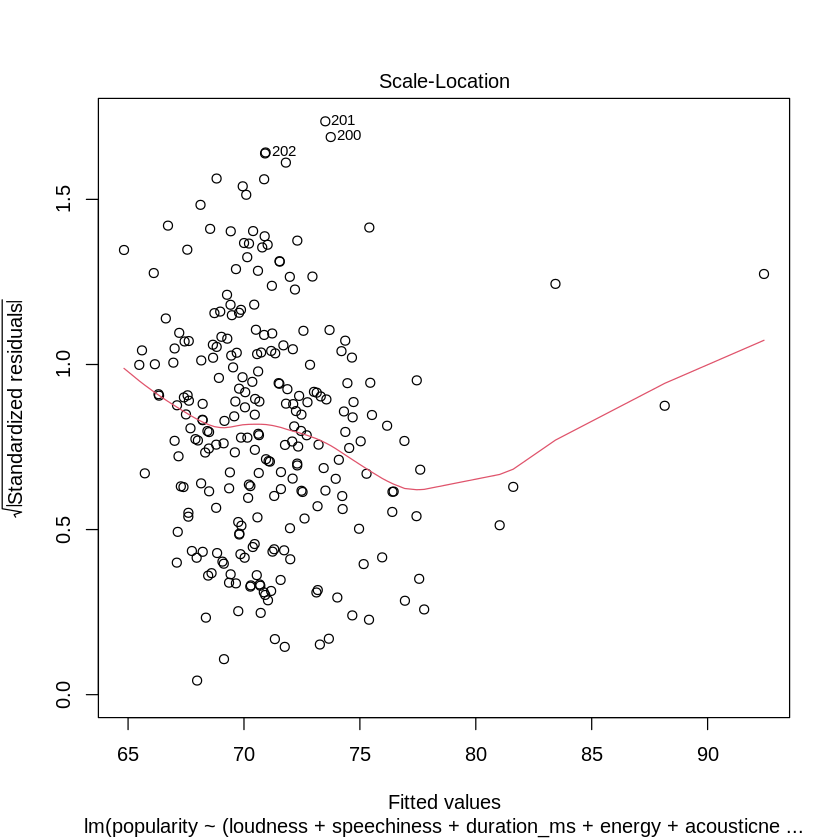

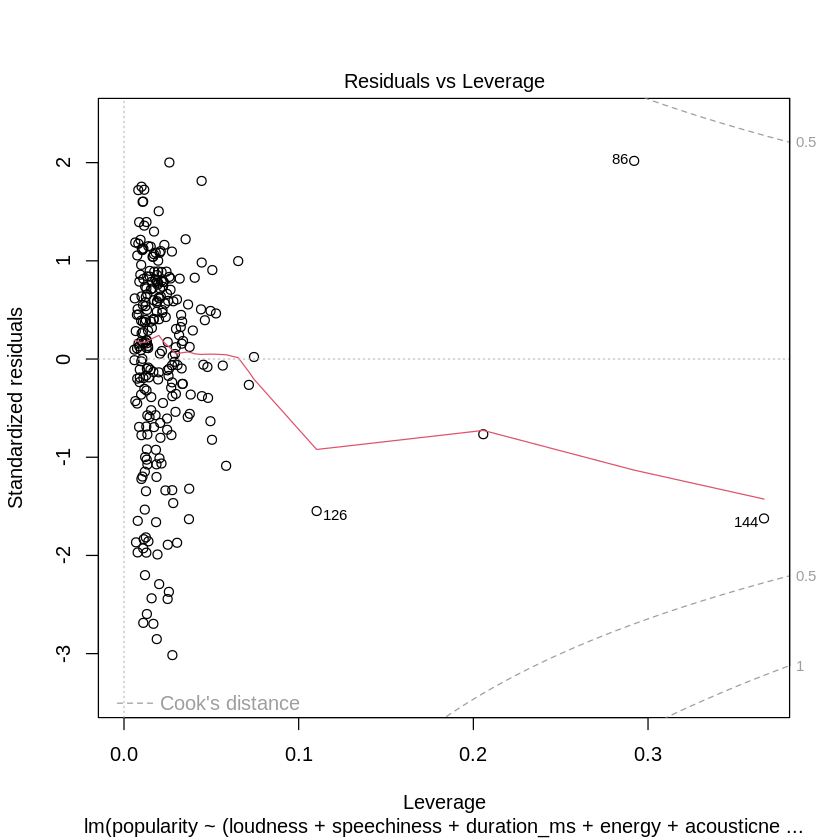

In [ ]:
summary(taylor_red_pwr)
plot(taylor_red_pwr)

In [ ]:
anova(trans_lm, taylor_red_box)

Res.Df RSS          Df  Sum of Sq     F        Pr(>F)     
1 199    5.196286e+12  NA            NA       NA          NA
2 240    7.044921e+12 -41 -1.848635e+12 1.726742 0.007503386

Full model is significantly different from reduced model

Maybe slightly better normalcy and error assumptions? Significantly reduced $R^2$ tho

In [ ]:
anova(ts_alb_lm, taylor_red_alb)

Res.Df RSS          Df Sum of Sq     F  Pr(>F)
1 233    9.383309e+03 NA            NA NA NA    
2 233    2.183849e+12  0 -2.183849e+12 NA NA

In [ ]:
anova(trans_pwr_lm, taylor_red_pwr)

Res.Df RSS      Df  Sum of Sq F        Pr(>F)    
1 183    24114.21  NA        NA       NA         NA
2 241    34377.62 -58 -10263.41 1.342894 0.07337088

Reduced model is not significantly different from full model. But its close and the full model has better assumption validaties. Might want to choose full!


Call:
lm(formula = popularity ~ loudness + speechiness, data = trans_pwr)

Residuals:
    Min      1Q  Median      3Q     Max 
-35.632  -6.403   1.570   8.683  23.956 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  63.9246     2.1821  29.296  < 2e-16 ***
loudness     -0.6739     0.2884  -2.336  0.02028 *  
speechiness  46.3293    14.9918   3.090  0.00223 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.92 on 244 degrees of freedom
Multiple R-squared:  0.06875,	Adjusted R-squared:  0.06112 
F-statistic: 9.007 on 2 and 244 DF,  p-value: 0.0001683


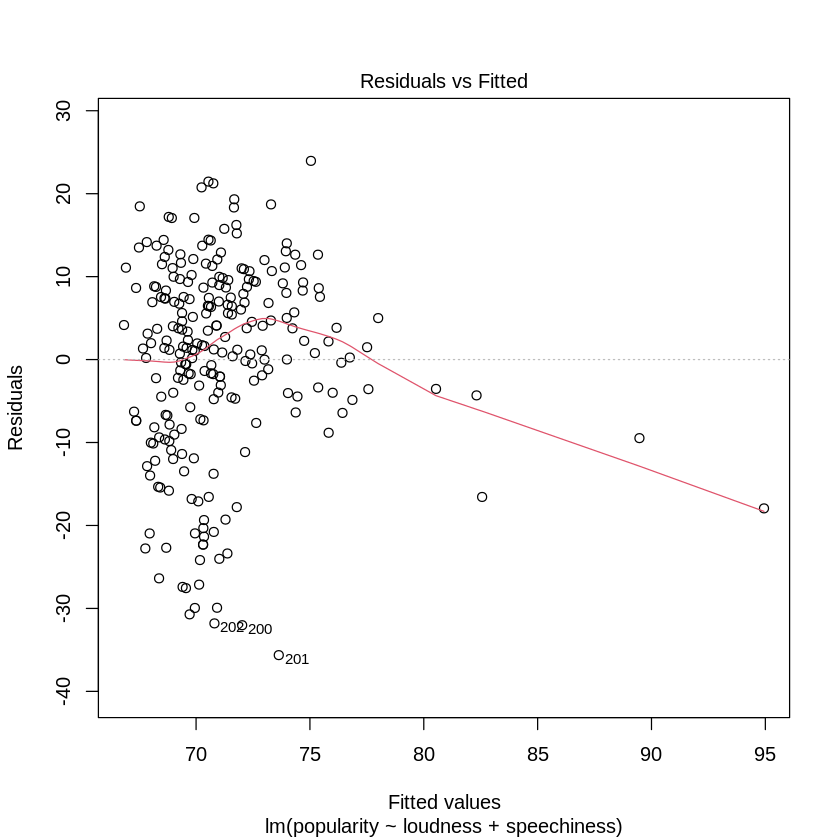

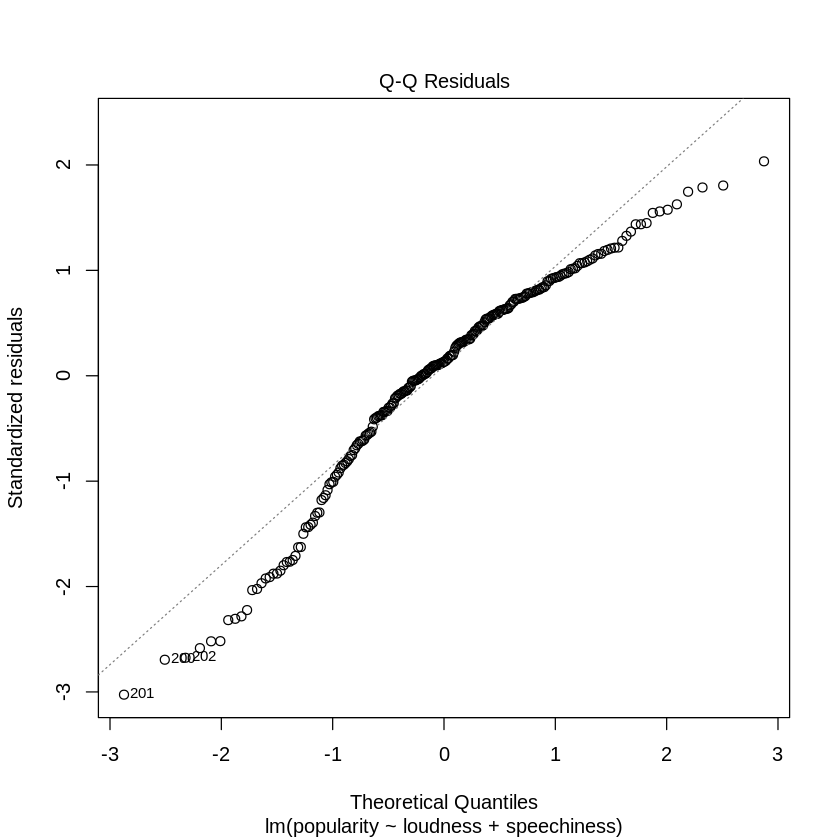

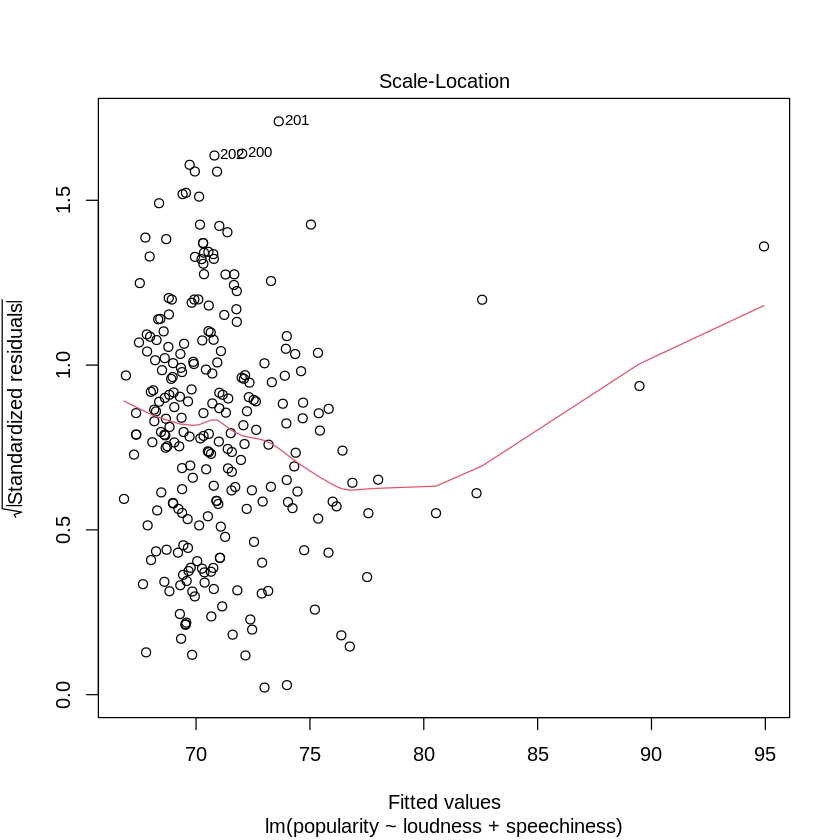

bcPower Transformations to Multinormality 
            Est Power Rounded Pwr Wald Lwr Bnd Wald Upr Bnd
popularity     3.7563        3.76       2.7791       4.7336
loudness       1.6656        2.00       1.3244       2.0068
speechiness  -30.8814      -30.88     -35.8390     -25.9238

Likelihood ratio test that transformation parameters are equal to 0
 (all log transformations)
                               LRT df       pval
LR test, lambda = (0 0 0) 587.4354  3 < 2.22e-16

Likelihood ratio test that no transformations are needed
                               LRT df       pval
LR test, lambda = (1 1 1) 483.6301  3 < 2.22e-16

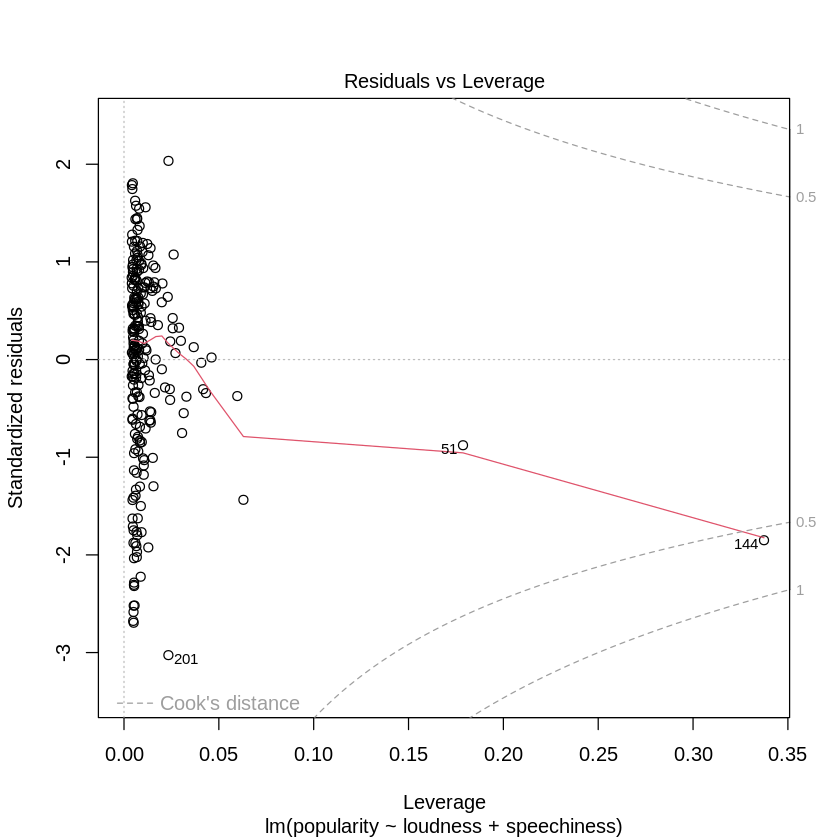

In [ ]:
test <- lm(popularity ~ loudness + speechiness, data = trans_pwr)
summary(test)
plot(test)
summary(powerTransform(cbind(popularity, loudness, speechiness)~1, data = ts_data_pos))

Similar R^2

### Stuff for Mini Assignment 2

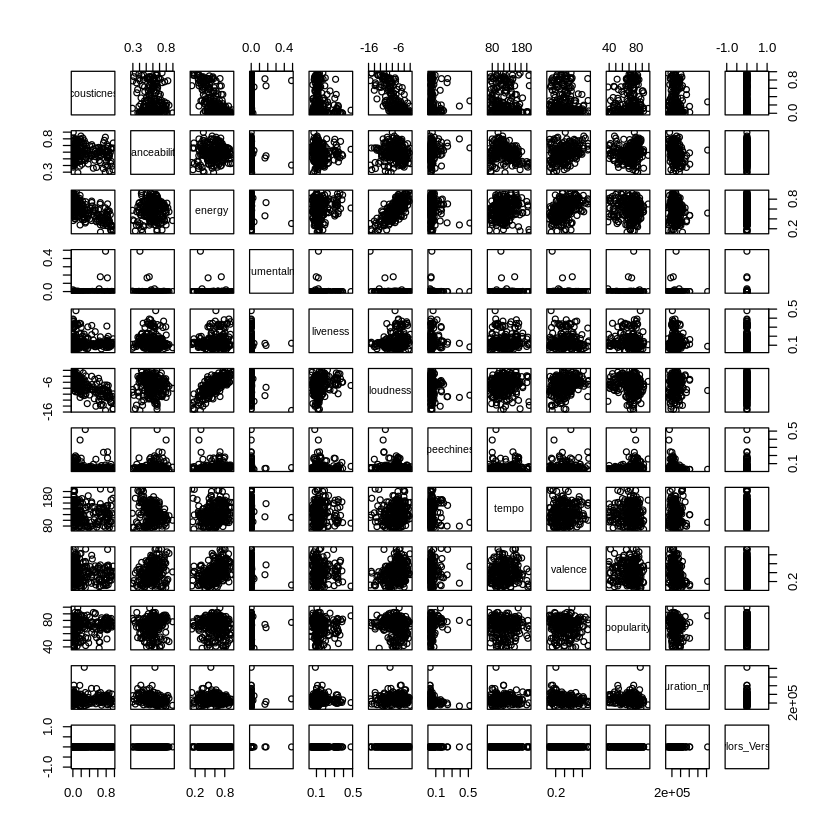

In [ ]:
ts_data_clean %>%
  select_if(is.numeric) %>%
pairs()

In [ ]:
which(is.numeric(ts_data_clean))

ERROR: Error in eval(expr, envir, enclos): object 'ts_data_clean' not found


New names:
• `` -> `...1`
Rows: 530 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): name, album, id, uri
dbl  (13): ...1, track_number, acousticness, danceability, energy, instrumen...
date  (1): release_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Call:
lm(formula = popularity ~ ., data = ts_final)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.6114  -5.4165  -0.2731   5.0284  27.1442 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -6.869e+00  7.407e+00  -0.927 0.354315    
release_date  5.475e-03  3.103e-04  17.644  < 2e-16 ***
acousticness  5.537e+00  2.122e+00   2.609 0.009409 ** 
danceability -3.102e+00  4.213e+00  -0.736 0.462006    
energy        3.676e-01  4.129e+00   0.089 0.929094    
liveness     -1.098e+01  4.623e+00  -2.376 0.017957 *  
loudness     -1.388e+00  2.886e-01  -4.810 2.12e-06 ***
speechiness  -3.238e+00  5.882e+00  -0.550 0.582285    
tempo        -8.739e-03  1.355e-02  -0.645 0.519206    
valence      -2.778e+00  2.552e+00  -1.089 0.276871    
duration_ms  -1.910e-05  1.029e-05  -1.856 0.064108 .  
deluxe       -7.044e+00  8.689e-01  -8.107 5.96e-15 ***
tv           -4.321e+00  1.277e+00  -3.384 0.000784 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 

Df  Sum Sq       Mean Sq      F value      Pr(>F)      
release_date   1 39931.672776 39931.672776 636.09225134 1.251218e-85
acousticness   1    91.396330    91.396330   1.45589937 2.282744e-01
danceability   1    73.015507    73.015507   1.16310175 2.814527e-01
energy         1   395.751464   395.751464   6.30412958 1.242677e-02
liveness       1   313.409419   313.409419   4.99246059 2.599234e-02
loudness       1  1218.021438  1218.021438  19.40249293 1.350593e-05
speechiness    1     5.750027     5.750027   0.09159515 7.623113e-01
tempo          1    39.959066    39.959066   0.63652862 4.254291e-01
valence        1   120.098526   120.098526   1.91311149 1.673653e-01
duration_ms    1   636.733495   636.733495  10.14285688 1.558438e-03
deluxe         1  4168.718018  4168.718018  66.40566360 4.417251e-15
tv             1   718.752151   718.752151  11.44937445 7.835026e-04
Residuals    413 25926.712394    62.776543           NA           NA

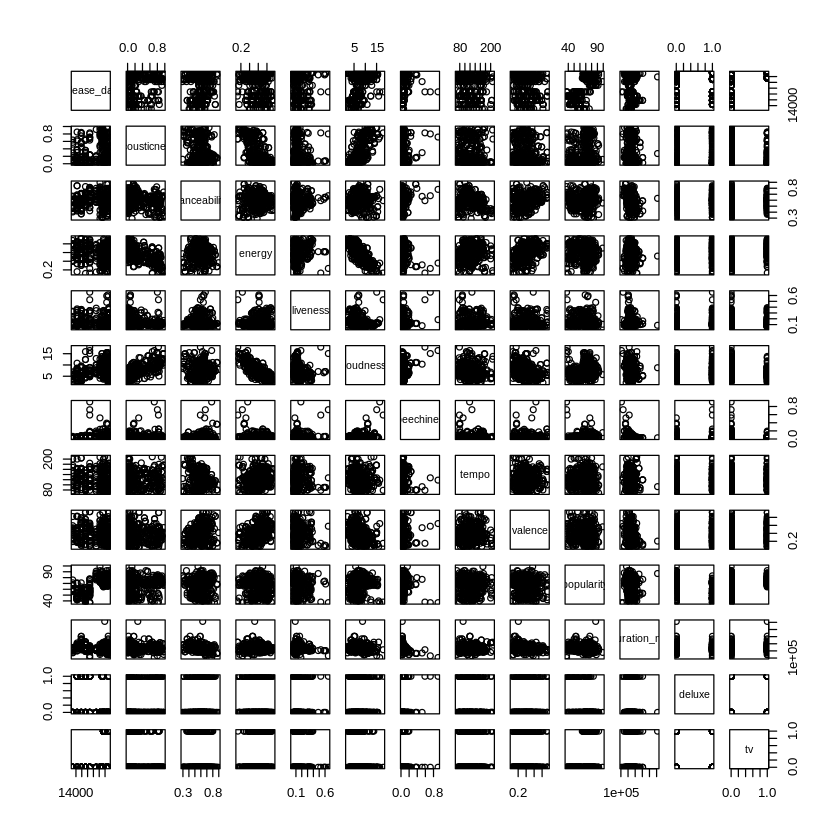

bcPower Transformations to Multinormality 
             Est Power Rounded Pwr Wald Lwr Bnd Wald Upr Bnd
acousticness    0.3330        0.33       0.2799       0.3861
danceability    1.4719        1.47       1.0876       1.8562
energy          1.1814        1.00       0.9929       1.3698
liveness       -0.4697       -0.50      -0.6174      -0.3219
loudness        0.5709        0.50       0.4195       0.7223
speechiness    -1.2454       -1.25      -1.4253      -1.0654
tempo           0.3648        0.00      -0.0168       0.7463
valence         0.6468        0.65       0.5112       0.7824
popularity      2.0258        2.00       1.5783       2.4733
duration_ms    -0.3476       -0.50      -0.6256      -0.0696

Likelihood ratio test that transformation parameters are equal to 0
 (all log transformations)
                                             LRT df       pval
LR test, lambda = (0 0 0 0 0 0 0 0 0 0) 979.2797 10 < 2.22e-16

Likelihood ratio test that no transformations are needed
      

Start:  AIC=1776.26
popularity ~ release_date + acousticness + danceability + energy + 
    liveness + loudness + speechiness + tempo + valence + duration_ms + 
    deluxe + tv

               Df Sum of Sq   RSS    AIC
- energy        1       0.5 25927 1774.3
- speechiness   1      19.0 25946 1774.6
- tempo         1      26.1 25953 1774.7
- danceability  1      34.0 25961 1774.8
- valence       1      74.4 26001 1775.5
<none>                      25927 1776.3
- duration_ms   1     216.3 26143 1777.8
- liveness      1     354.4 26281 1780.0
- acousticness  1     427.3 26354 1781.2
- tv            1     718.8 26645 1785.9
- loudness      1    1452.6 27379 1797.5
- deluxe        1    4125.8 30053 1837.2
- release_date  1   19541.9 45469 2013.6

Step:  AIC=1774.27
popularity ~ release_date + acousticness + danceability + liveness + 
    loudness + speechiness + tempo + valence + duration_ms + 
    deluxe + tv

               Df Sum of Sq   RSS    AIC
- speechiness   1      18.9 25946 1772


Call:
lm(formula = popularity ~ release_date + acousticness + liveness + 
    loudness + valence + duration_ms + deluxe + tv, data = ts_final)

Coefficients:
 (Intercept)  release_date  acousticness      liveness      loudness  
  -9.608e+00     5.479e-03     6.065e+00    -1.163e+01    -1.475e+00  
     valence   duration_ms        deluxe            tv  
  -3.396e+00    -1.658e-05    -7.037e+00    -4.288e+00  



Call:
lm(formula = popularity ~ release_date + acousticness + liveness + 
    loudness + speechiness + deluxe + tv, data = ts_trans)

Residuals:
    Min      1Q  Median      3Q     Max 
-2289.3  -709.1   -82.0   615.2  3899.3 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -5.258e+03  7.074e+02  -7.434 6.02e-13 ***
release_date  6.705e-01  4.339e-02  15.454  < 2e-16 ***
acousticness  6.375e+02  2.680e+02   2.379  0.01782 *  
liveness      2.502e+02  8.245e+01   3.035  0.00256 ** 
loudness     -8.572e+02  1.575e+02  -5.443 8.95e-08 ***
speechiness  -3.515e+00  2.276e+00  -1.545  0.12316    
deluxe       -9.047e+02  1.142e+02  -7.925 2.09e-14 ***
tv           -5.242e+02  1.731e+02  -3.029  0.00261 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1051 on 418 degrees of freedom
Multiple R-squared:  0.6168,	Adjusted R-squared:  0.6103 
F-statistic:  96.1 on 7 and 418 DF,  p-value: < 2.2e-16


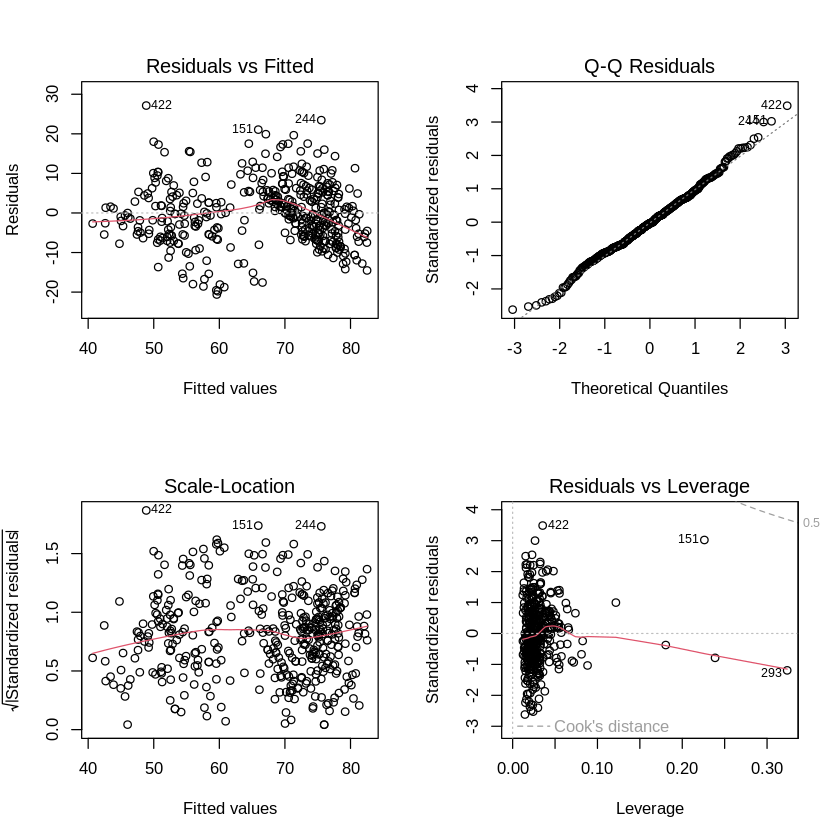

Df  Sum Sq    Mean Sq   F value    Pr(>F)      
release_date   1 621997246 621997246 562.979232 1.904818e-79
acousticness   1   1675928   1675928   1.516908 2.187804e-01
liveness       1   4816306   4816306   4.359312 3.741199e-02
loudness       1  24064760  24064760  21.781383 4.121306e-06
speechiness    1  11614007  11614007  10.512015 1.281056e-03
deluxe         1  68919413  68919413  62.380016 2.525112e-14
tv             1  10135107  10135107   9.173441 2.607765e-03
Residuals    418 461819609   1104832         NA           NA


Call:
lm(formula = popularity ~ release_date + acousticness + liveness + 
    loudness + speechiness + deluxe + tv, data = ts_trans)

Coefficients:
 (Intercept)  release_date  acousticness      liveness      loudness  
  -5258.3020        0.6705      637.4769      250.2292     -857.1515  
 speechiness        deluxe            tv  
     -3.5153     -904.7031     -524.2198  


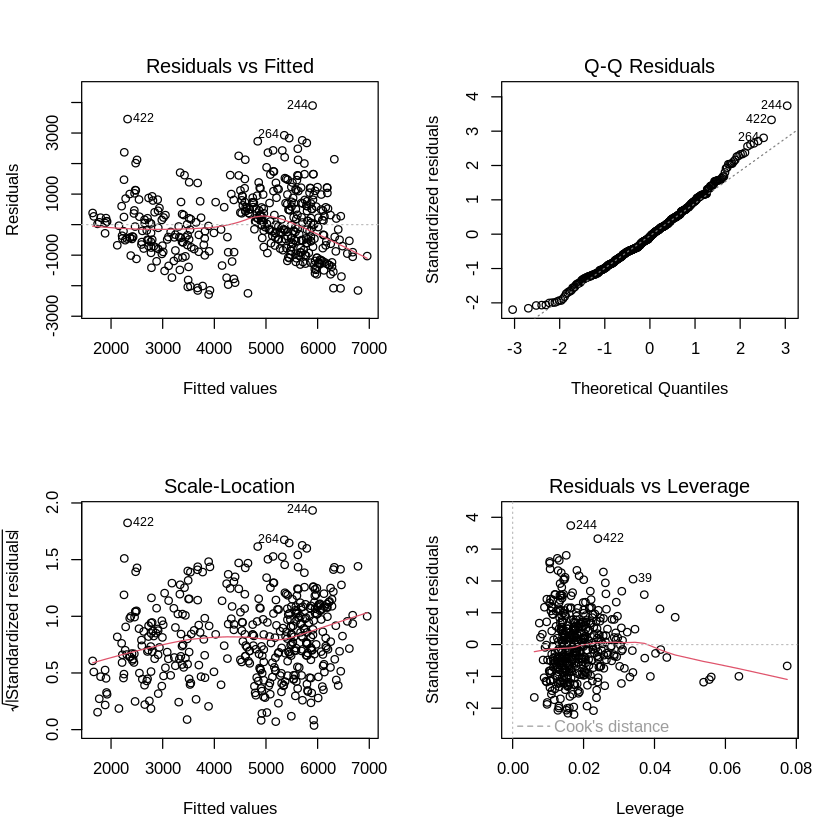

In [ ]:
# Mini assignment 2
suppressMessages(library(tidyverse))

ts_data <- dplyr::select(read_csv("taylor_swift_spotify.csv"), -(...1))
ts_clean <- ts_data %>%
	mutate("deluxe" = ifelse(str_detect(ts_data$album, "[Dd]eluxe") | str_detect(ts_data$album, "Platinum"), 1, 0),
				 "tv" = ifelse(str_detect(ts_data$album, "(Taylor's Version)"), 1, 0))

ts_clean <- ts_clean %>%
	filter(!(album %in% c("Live From Clear Channel Stripped 2008",
														 "reputation Stadium Tour Surprise Song Playlist",
														 "folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]",
														"Speak Now World Tour Live")))

ts_clean$loudness <- -1 * ts_clean$loudness

# Dropped Clear Channel, rep surprise songs, Speak Now Tour Live, and long pond songs.
# Keeping all of the rest as are actual albums.
# Added indicators for whether albums are deluxe or taylor's version, which
# should allow us to forget about the specific album (identical song should have the
# same scores across categories).

# Removing all of the text variables for actual analysis:

ts_final <- dplyr::select(ts_clean, -c(name, album, id, uri, track_number, instrumentalness))
# Mini assignment question 1

plot(ts_final)

# There appear to be a range of relationships across the variables.
# There exists linearity between some variables, especially loudness and energy,
# acousticness and energy, valence and danceability, and others.
# However, a few variables show complete random scatter. Some of these, like
# release date, make some sense, the music of Taylor Swift has pretty similar
# characteristics throughout her career, at least compared to all types of music,
# while others, say the relation between energy and tempo, less so.

# Question 2
prelim_model <- lm(popularity ~ ., data = ts_final)
summary(prelim_model)
anova(prelim_model)

# R^2: 0.6485
# ANOVA p-values:

# Question 3
par(mfrow = c(2,2))
plot(prelim_model)


# The assumption of constant variance appears to be satisfied,
# as does the mean of the error being centered around 0.
# The normality of the errors is mostly satisfied, with a few points straying somewhat from their expected values.
# There are no highly influential points, but a few that should be investigated further:
# 422, 151, and 244, which are marked as outliers on the first 3 plots. These are the songs:
# All Too Well (10 Minute Version) (shockingly the insanely long, insanely popular
# one is an outlier), Cruel Summer (the most popular song of 2023), and Our Song
# (her first majorly popular song, has a very old release date).

# Question 4

library(car)
summary(powerTransform(dplyr::select(ts_final, -c(release_date, deluxe, tv))))

# First note that we cannot transform the dates or the binary variables, as this
# violates their inherent properties.

# We adjust the variables to have the correct powers:

ts_trans <- transmute(ts_final, release_date, "acousticness" = acousticness ^ 0.33,
											"danceability" = danceability ^ 1.47, energy,
											"liveness" = liveness ^ -0.5, "loudness" = loudness ^ 0.5,
											"speechiness" = speechiness ^ -1.25, "tempo" = log(tempo),
											"valence" = valence ^ 0.65, "popularity" = popularity ^ 2,
											"duration_ms" = duration_ms ^ -0.5, deluxe, tv)

# We recreate the model:

updated_model <- lm(popularity ~ ., data = ts_trans)

# Question 5
step(prelim_model, direction = "backward")

#Suggests:
# popularity = b0 + b1 release_date + b2 acousticness + b3 liveness +
# 						 b4 loudness + b5 valence + b6 duration_ms + b7 deluxe + b8 tv



# Question 6
superior_model <- lm(popularity ~ release_date + acousticness + liveness +
										 	loudness + speechiness + deluxe + tv, data = ts_trans)
summary(superior_model)
par(mfrow = c(2,2))
plot(superior_model)
anova(superior_model)

# Question 7
superior_model



In [ ]:
full_model <- lm(popularity ~ release_date * acousticness * liveness *
										 	loudness * speechiness * deluxe * tv * valence *
                      duration_ms, data = ts_trans)
test <- step(full_model, direction = 'backward' )


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



New names:
• `` -> `...1`
Rows: 530 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): name, album, id, uri
dbl  (13): ...1, track_number, acousticness, danceability, energy, instrumen...
date  (1): release_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Call:
lm(formula = popularity ~ ., data = ts_final)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.6114  -5.4165  -0.2731   5.0284  27.1442 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -6.869e+00  7.407e+00  -0.927 0.354315    
release_date  5.475e-03  3.103e-04  17.644  < 2e-16 ***
acousticness  5.537e+00  2.122e+00   2.609 0.009409 ** 
danceability -3.102e+00  4.213e+00  -0.736 0.462006    
energy        3.676e-01  4.129e+00   0.089 0.929094    
liveness     -1.098e+01  4.623e+00  -2.376 0.017957 *  
loudness     -1.388e+00  2.886e-01  -4.810 2.12e-06 ***
speechiness  -3.238e+00  5.882e+00  -0.550 0.582285    
tempo        -8.739e-03  1.355e-02  -0.645 0.519206    
valence      -2.778e+00  2.552e+00  -1.089 0.276871    
duration_ms  -1.910e-05  1.029e-05  -1.856 0.064108 .  
deluxe       -7.044e+00  8.689e-01  -8.107 5.96e-15 ***
tv           -4.321e+00  1.277e+00  -3.384 0.000784 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 

Df  Sum Sq       Mean Sq      F value      Pr(>F)      
release_date   1 39931.672776 39931.672776 636.09225134 1.251218e-85
acousticness   1    91.396330    91.396330   1.45589937 2.282744e-01
danceability   1    73.015507    73.015507   1.16310175 2.814527e-01
energy         1   395.751464   395.751464   6.30412958 1.242677e-02
liveness       1   313.409419   313.409419   4.99246059 2.599234e-02
loudness       1  1218.021438  1218.021438  19.40249293 1.350593e-05
speechiness    1     5.750027     5.750027   0.09159515 7.623113e-01
tempo          1    39.959066    39.959066   0.63652862 4.254291e-01
valence        1   120.098526   120.098526   1.91311149 1.673653e-01
duration_ms    1   636.733495   636.733495  10.14285688 1.558438e-03
deluxe         1  4168.718018  4168.718018  66.40566360 4.417251e-15
tv             1   718.752151   718.752151  11.44937445 7.835026e-04
Residuals    413 25926.712394    62.776543           NA           NA

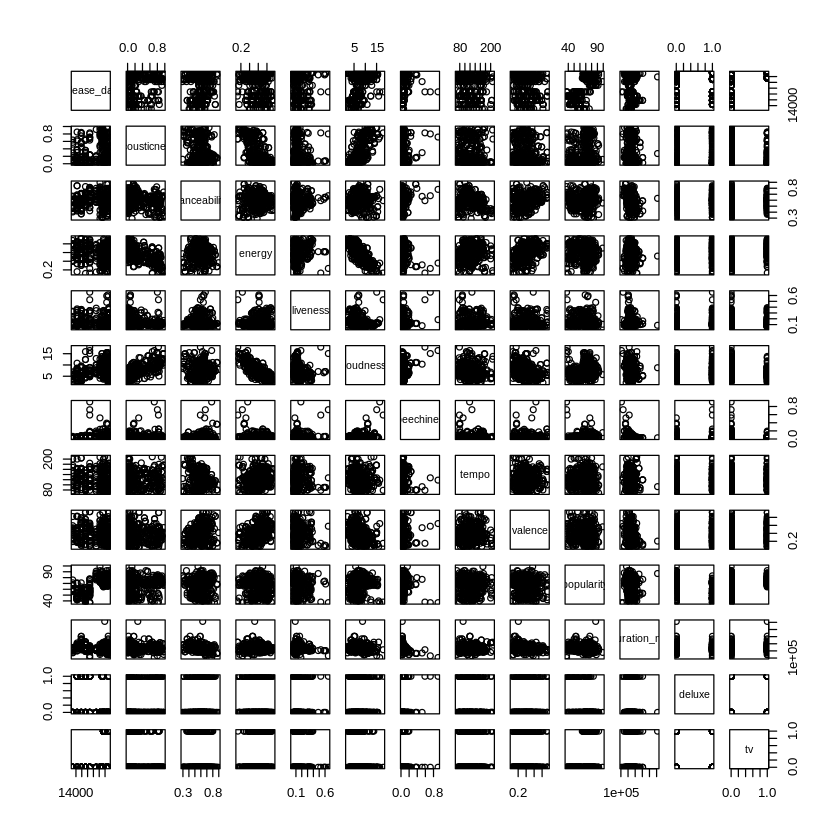

ERROR: Error in library(car): there is no package called ‘car’


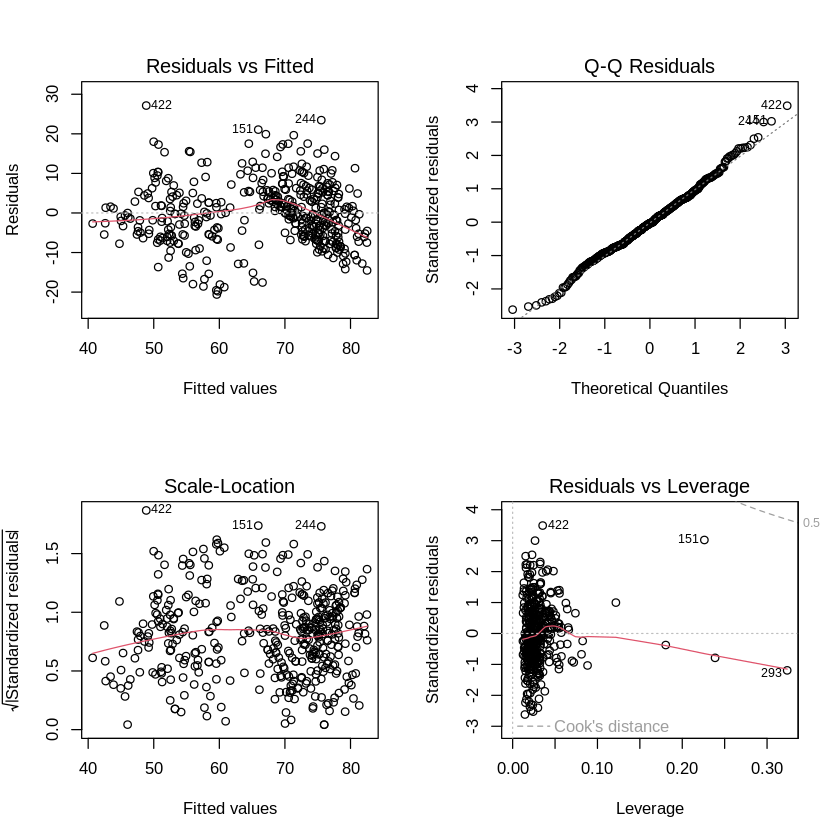

In [ ]:
# New models
suppressMessages(library(tidyverse))

ts_data <- select(read_csv("taylor_swift_spotify.csv"), -(...1))

ts_clean <- ts_data %>%
	mutate("deluxe" = ifelse(str_detect(ts_data$album, "[Dd]eluxe") | str_detect(ts_data$album, "Platinum"), 1, 0),
				 "tv" = ifelse(str_detect(ts_data$album, "(Taylor's Version)"), 1, 0))

ts_clean <- ts_clean %>%
	filter(!(album %in% c("Live From Clear Channel Stripped 2008",
														 "reputation Stadium Tour Surprise Song Playlist",
														 "folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]",
														"Speak Now World Tour Live")))

ts_clean$loudness <- -1 * ts_clean$loudness

# Dropped Clear Channel, rep surprise songs, Speak Now Tour Live, and long pond songs.
# Keeping all of the rest as are actual albums.
# Added indicators for whether albums are deluxe or taylor's version, which
# should allow us to forget about the specific album (identical song should have the
# same scores across categories).

# Removing all of the text variables for actual analysis:

ts_final <- select(ts_clean, -c(name, album, id, uri, track_number, instrumentalness))


# Mini assignment question 1

plot(ts_final)

# There appear to be a range of relationships across the variables.
# There exists linearity between some variables, especially loudness and energy,
# acousticness and energy, valence and danceability, and others.
# However, a few variables show complete random scatter. Some of these, like
# release date, make some sense, the music of Taylor Swift has pretty similar
# characteristics throughout her career, at least compared to all types of music,
# while others, say the relation between energy and tempo, less so.

# Question 2
prelim_model <- lm(popularity ~ ., data = ts_final)
summary(prelim_model)
anova(prelim_model)

# R^2: 0.6485
# ANOVA p-values:

# Question 3
par(mfrow = c(2,2))
plot(prelim_model)


# The assumption of constant variance appears to be satisfied,
# as does the mean of the error being centered around 0.
# The normality of the errors is mostly satisfied, with a few points straying somewhat from their expected values.
# There are no highly influential points, but a few that should be investigated further:
# 422, 151, and 244, which are marked as outliers on the first 3 plots. These are the songs:
# All Too Well (10 Minute Version) (shockingly the insanely long, insanely popular
# one is an outlier), Cruel Summer (the most popular song of 2023), and Our Song
# (her first majorly popular song, has a very old release date).

# Question 4

library(car)
summary(powerTransform(select(ts_final, -c(release_date, deluxe, tv))))

# First note that we cannot transform the dates or the binary variables, as this
# violates their inherent properties.

# We adjust the variables to have the correct powers:

ts_trans <- transmute(ts_final, release_date, "acousticness" = acousticness ^ 0.33,
											"danceability" = danceability ^ 1.47, energy,
											"liveness" = liveness ^ -0.5, "loudness" = loudness ^ 0.5,
											"speechiness" = speechiness ^ -1.25, "tempo" = log(tempo),
											"valence" = valence ^ 0.65, "popularity" = popularity ^ 2,
											"duration_ms" = duration_ms ^ -0.5, deluxe, tv)

# We recreate the model:

updated_model <- lm(popularity ~ ., data = ts_trans)

# Question 5
step(prelim_model, direction = "backward")

#Suggests:
# popularity = b0 + b1 release_date + b2 acousticness + b3 liveness +
# 						 b4 loudness + b5 valence + b6 duration_ms + b7 deluxe + b8 tv



# Question 6
superior_model <- lm(popularity ~ release_date + acousticness + liveness +
										 	loudness + valence + duration_ms + deluxe + tv, data = ts_final)
summary(superior_model)
par(mfrow = c(2,2))
plot(superior_model)
anova(superior_model)

# Question 7
superior_model



extractAIC(prelim_model, k = log(426))[2] # Biggest dataset
extractAIC(superior_model, k = log(426))[2] # Stepwise regression of prelim
extractAIC(updated_model, k = log(426))[2] # Based on transformed data

AIC(prelim_model, superior_model, updated_model)
summary(prelim_model)


matrix(c(
	summary(prelim_model)$adj.r.squared, # adjusted R2
	extractAIC(prelim_model)[2], # AIC
	extractAIC(prelim_model)[2] + 2 * (length(prelim_model$coefficients) + 1) *
		(length(prelim_model$coefficients) + 2) / (nrow(ts_clean) -
																					 	length(prelim_model$coefficients)), #AICc
	extractAIC(prelim_model, k = log(nrow(ts_clean)))[2], #BIC
	summary(superior_model)$adj.r.squared, # R2
	extractAIC(superior_model)[2], # AIC
	extractAIC(superior_model)[2] + 2 * (length(superior_model$coefficients) + 1) *
		(length(superior_model$coefficients) + 2) / (nrow(ts_clean) -
																					 	length(superior_model$coefficients)), # AICc
	extractAIC(superior_model, k = log(nrow(ts_clean)))[2], # BIC
	summary(updated_model)$adj.r.squared, # R2
	extractAIC(updated_model)[2], # AIC
	extractAIC(updated_model)[2] + 2 * (length(updated_model$coefficients) + 1) *
		(length(updated_model$coefficients) + 2) / (nrow(ts_clean) -
																					 	length(updated_model$coefficients)), # AICc
	extractAIC(updated_model, k = log(nrow(ts_clean)))[2]), # BIC
	nrow = 3, byrow = TRUE,
	dimnames = list(c("Full Model", "Stepwise Model", "Transformed Data"),
									c("Adjusted R^2", "AIC", "AIC Corrected", "BIC")))
